In [1]:
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
from coffea.util import load
import hist
import os
from pprint import pprint 
hep.style.use(hep.style.ROOT)
import vector
vector.register_awkward()
import hist
import numba

In [27]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/TTbar_MC_Run3_v2/"

In [6]:
input_folder_must = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTbar_14TeV_TuneCP5_Pythia8/RawDumper_Mustache_12_5_0/"
input_folder_deep = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTbar_14TeV_TuneCP5_Pythia8/RawDumper_DeepSC_12_5_0/"

In [107]:
dfM = uproot.lazy([f"{input_folder_must}/ttbar_Run3_Mustache.root:recosimdumper/caloTree",], num_workers=20)
dfD = uproot.lazy([f"{input_folder_deep}/ttbar_Run3_DeepSC_algoA.root:recosimdumper/caloTree", ],num_workers=20)

In [15]:
def plot_hist(dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, flatten=False, density=False,
                    legend="DeepSC", text=None, llabel="Simulation Preliminary",rlabel="14 TeV",
                   texty=.75, cmslabel="TTbar Run3"):
    
    fig = plt.figure(figsize=(10,9), dpi=150)
    ax = plt.gca()
    
    if flatten:
        dfA = ak.flatten(dfA)
    
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label=legend, histtype="step", linewidth=2, density=density)
    
    print("A.", np.sum(A))

    ax.legend()
    ax.set_xlabel(label)
    
    if text!=None:
        ax.text(0.07, texty, text, transform=ax.transAxes, fontsize="small")
        
    #hep.cms.label(llabel=llabel, rlabel=rlabel, loc=0, ax=ax)
    
   
    mmax = max(A)
    if ylog:
        ax.set_ylim(max(min(A), 1), mmax*200)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)
         
    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
        


def plot_comparison(dfB, dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, wB=None, flatten=False,density=False,
                    legendB="Mustache", legendA="DeepSC", text=None, ratio_lim=(0.8,1.2),
                   texty=.75, rlabel="14 TeV",llabel="Simulation Preliminary"):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    plt.subplots_adjust(hspace=0.08)
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    if flatten:
        dfA = ak.flatten(dfA)
        dfB = ak.flatten(dfB)
    
    B, binX, _ = ax.hist(dfB, bins=bins, range=xrange,  weights=wB,
                         label=legendB, histtype="step", linewidth=2, density=density)
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label=legendA, histtype="step", linewidth=2, density=density)
    
    print("B:", np.sum(B))
    print("A.", np.sum(A))
    
    if density:
        errA,_ = np.histogram(dfA, bins=bins, range=xrange, weights=wA)
        errB,_ = np.histogram(dfB, bins=bins, range=xrange, weights=wB)
    else:
        errA = np.sqrt(A)
        errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(label)
    
    if text!=None:
        ax.text(0.07, texty, text, transform=ax.transAxes, fontsize="small")
        
    hep.cms.label(llabel=llabel, rlabel=rlabel, loc=0, ax=ax)
    
   
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*300)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)
         

    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    centers = (np.roll(binX, -1) + binX)/2
 
    axr.errorbar(centers[:-1], ratio, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")
    
    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio D/M")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
        
        
def plot_comparison_H(Hb, Ha, var, output_folder, legendB="Mustache", legendA="DeepSC", 
                    ylog=False, density=False, ratio_lim=(0.9, 1.1)):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    hep.histplot(Hb, label=legendB, density=density, ax=ax, linewidth=2)
    hep.histplot(Ha, label=legendA, density=density, ax=ax, linewidth=2)
        
    A = Ha.values()
    B = Hb.values()
    errA = np.sqrt(A)
    errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(Ha.axes[0].label)
    hep.cms.label(llabel="Data", rlabel="Run2018C Zee skim", loc=0, ax=ax)
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)


    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    if isinstance(Ha.axes[0], hist.axis.Integer):
        centers = Ha.axes[0].centers -1 
        edges = Ha.axes[0].edges -1
    else:
        centers = Ha.axes[0].centers
        edges = Ha.axes[0].edges
    
 
    axr.errorbar(centers, ratio, xerr=0, yerr=errR,
                fmt=".", linestyle='none', elinewidth=1, c="black")

    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio")
    axr.grid(which="both",axis="y")
    axr.plot([edges[0], edges[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
    


## SuperCluster

B: 1820727.0
A. 1549631.0


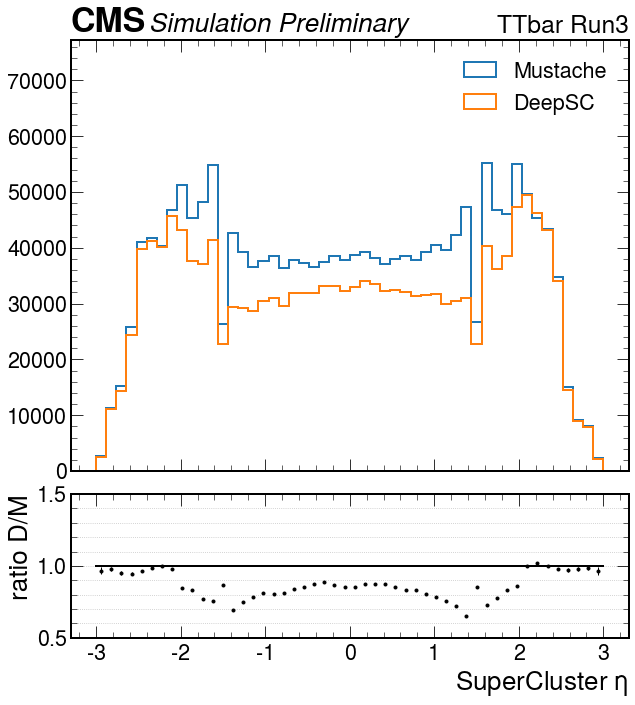

In [114]:
plot_comparison(ak.flatten(dfM.superCluster_eta), ak.flatten(dfD.superCluster_eta),
                var=f"SC_eta", label="SuperCluster $\eta$",
                output_folder=output_folder,
                bins=50, xrange=(-3,3), ratio_lim=(0.5,1.5))

B: 1757915.0
A. 1472515.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


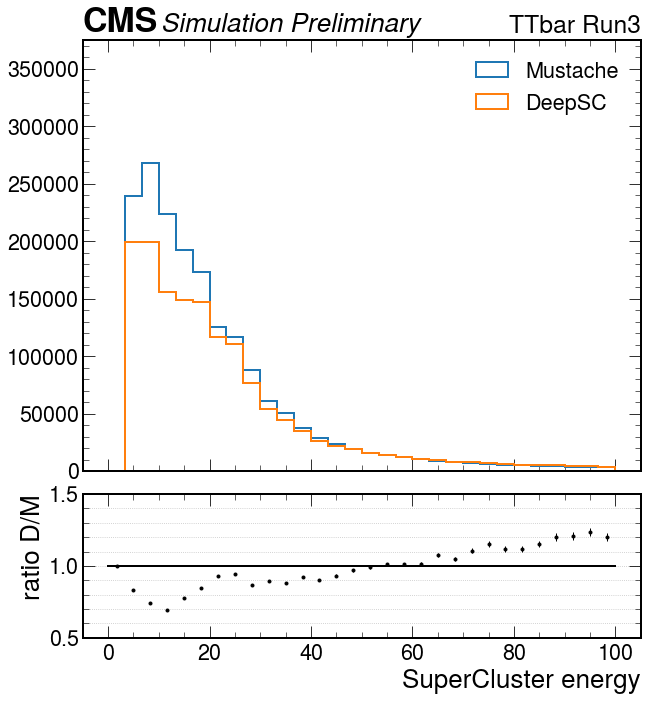

In [115]:
plot_comparison(ak.flatten(dfM.superCluster_energy), ak.flatten(dfD.superCluster_energy),
                var=f"SC_energy", label="SuperCluster energy",
                output_folder=output_folder,
                bins=30, xrange=(0,100), ratio_lim=(0.5,1.5))

B: 99950.0
A. 100000.0


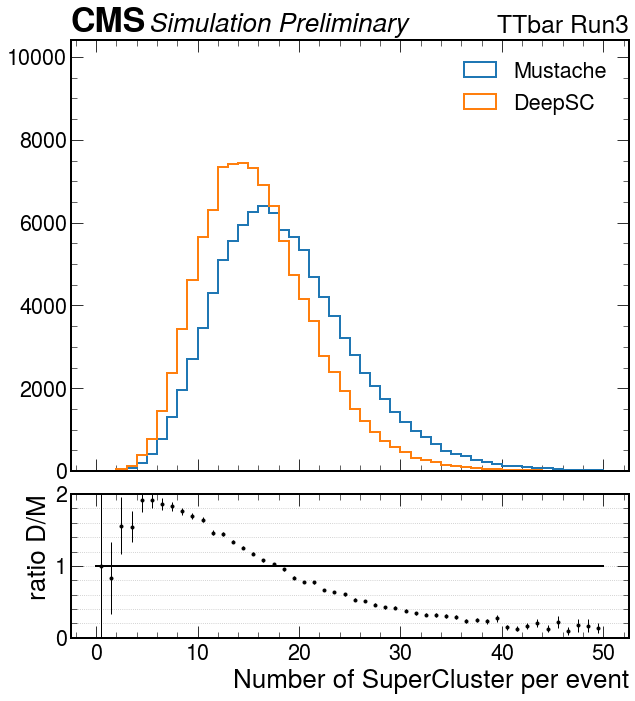

In [116]:
plot_comparison(ak.num(dfM.superCluster_energy,axis=1), ak.num(dfD.superCluster_energy,axis=1),
                var=f"nSC", label="Number of SuperCluster per event",
                output_folder=output_folder,
                bins=50, xrange=(0,50), ratio_lim=(0,2))

## Pat Electron

B: 100000.0
A. 100000.0


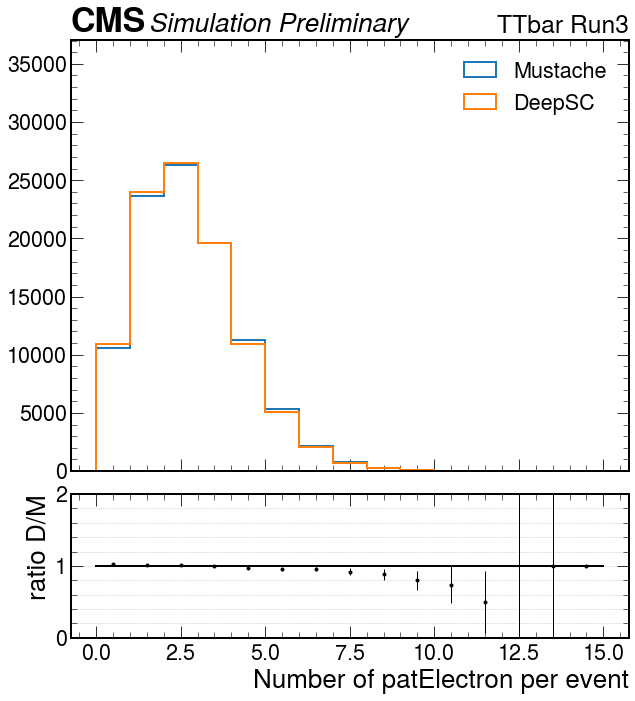

In [117]:
plot_comparison(ak.num(dfM.patElectron_energy,axis=1), ak.num(dfD.patElectron_energy,axis=1),
                var=f"npatele", label="Number of patElectron per event",
                output_folder=output_folder,
                bins=15, xrange=(0,15), ratio_lim=(0,2))

B: 99973.0
A. 99985.0


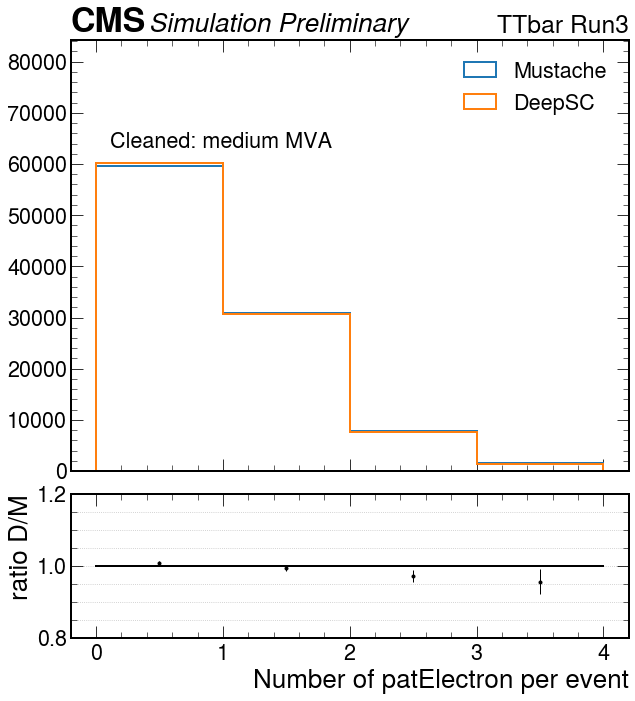

In [118]:
plot_comparison(ak.num(dfM.patElectron_energy[dfM.patElectron_egmMVAElectronIDmedium==1],axis=1), 
                ak.num(dfD.patElectron_energy[dfD.patElectron_egmMVAElectronIDmedium==1],axis=1),
                var=f"npatele_cleaned", label="Number of patElectron per event",
                text="Cleaned: medium MVA",
                output_folder=output_folder,
                bins=4, xrange=(0,4))

B: 228073.0
A. 224562.0


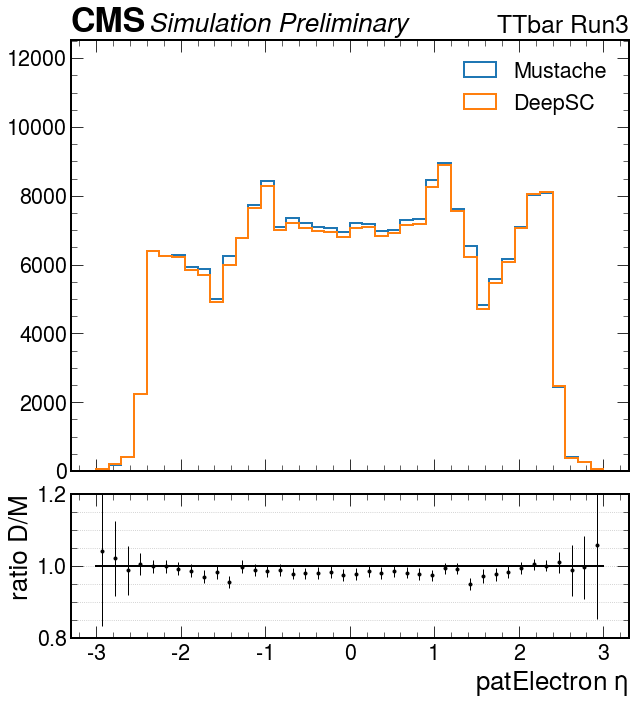

In [119]:
plot_comparison(ak.flatten(dfM.patElectron_eta,axis=1), ak.flatten(dfD.patElectron_eta,axis=1),
                var=f"patElectron_eta", label="patElectron $\eta$",
                output_folder=output_folder,
                bins=40, xrange=(-3,3))

B: 51428.0
A. 50534.0


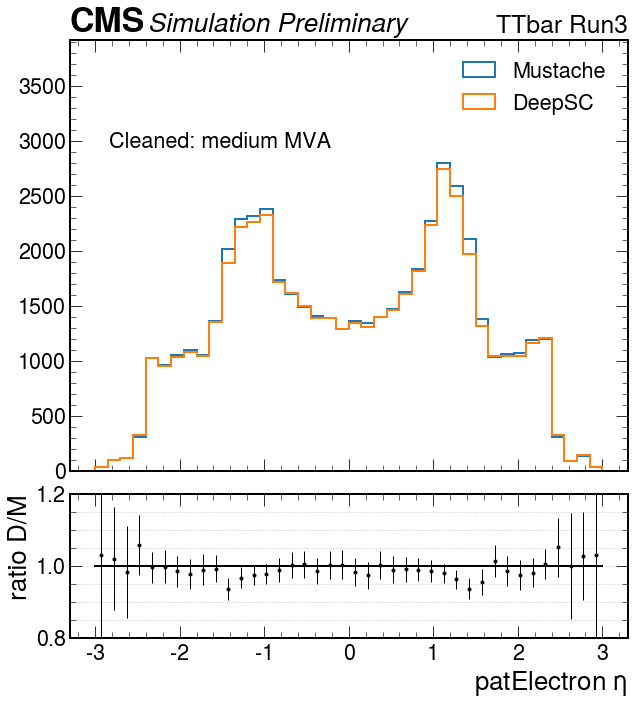

In [120]:
plot_comparison(ak.flatten(dfM.patElectron_eta[dfM.patElectron_egmMVAElectronIDmedium==1],axis=1), 
                ak.flatten(dfD.patElectron_eta[dfD.patElectron_egmMVAElectronIDmedium==1],axis=1),
                var=f"patElectron_eta_cleaned", label="patElectron $\eta$",
                text="Cleaned: medium MVA",
                output_folder=output_folder,
                bins=40, xrange=(-3,3))

B: 219424.0
A. 215309.0


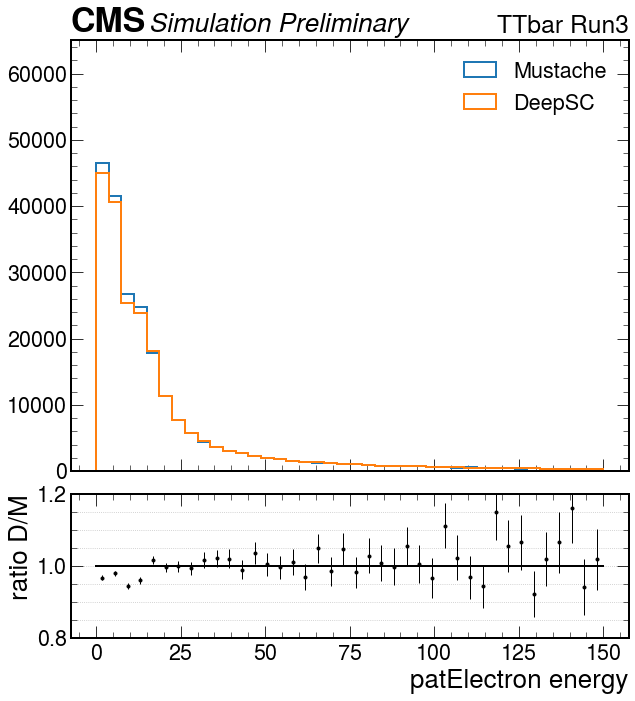

In [121]:
plot_comparison(ak.flatten(dfM.patElectron_energy,axis=1), ak.flatten(dfD.patElectron_energy,axis=1),
                var=f"patElectron_energy", label="patElectron energy",
                output_folder=output_folder,
                bins=40, xrange=(0,150))

B: 47964.0
A. 47082.0


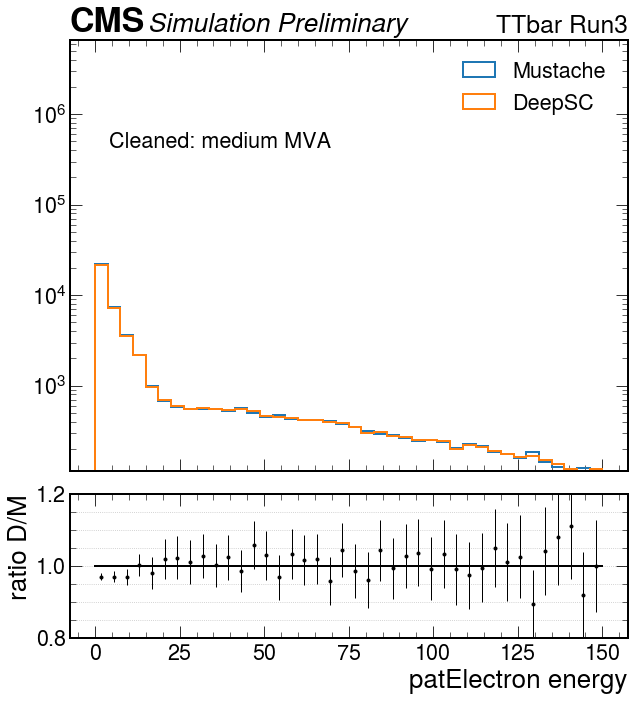

In [122]:
plot_comparison(ak.flatten(dfM.patElectron_energy[dfM.patElectron_egmMVAElectronIDmedium==1],axis=1), 
                ak.flatten(dfD.patElectron_energy[dfD.patElectron_egmMVAElectronIDmedium==1],axis=1),
                var=f"patElectron_energy_cleaned", label="patElectron energy",
                text="Cleaned: medium MVA", ylog=True,
                output_folder=output_folder,
                bins=40, xrange=(0,150))

## patJets

In [123]:
ak.num(dfM.patJet_energy)

<Array [58, 55, 52, 68, 69, ... 71, 74, 62, 56] type='100000 * int64'>

B: 100000.0
A. 100000.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


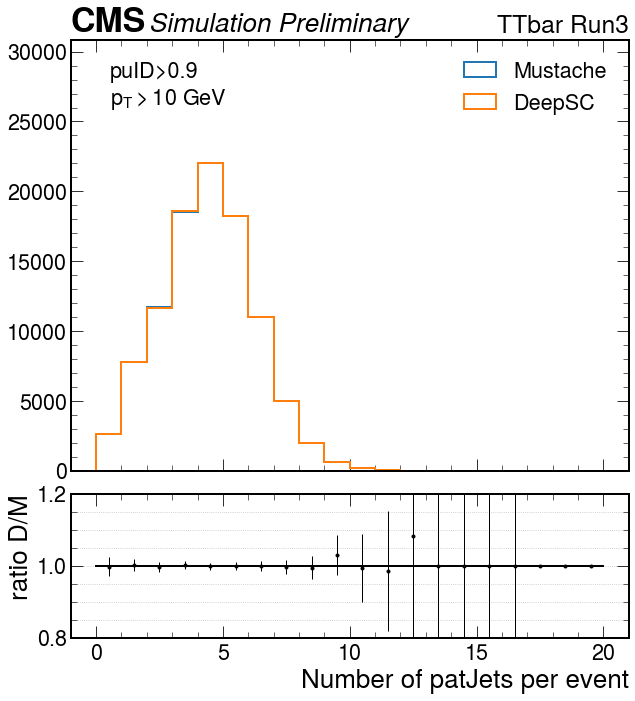

In [124]:
plot_comparison(ak.num(dfM.patJet_energy[(dfM.patJet_pt>10)&(dfM.patJet_puID>0.9)],axis=1), 
                ak.num(dfD.patJet_energy[(dfD.patJet_pt>10)&(dfD.patJet_puID>0.9)],axis=1),
                var=f"npatjet", label="Number of patJets per event",
                text="puID>0.9\n$p_T>10$ GeV", texty=0.85,                
                output_folder=output_folder,
                bins=20, xrange=(0,20))

B: 369538.0
A. 369523.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


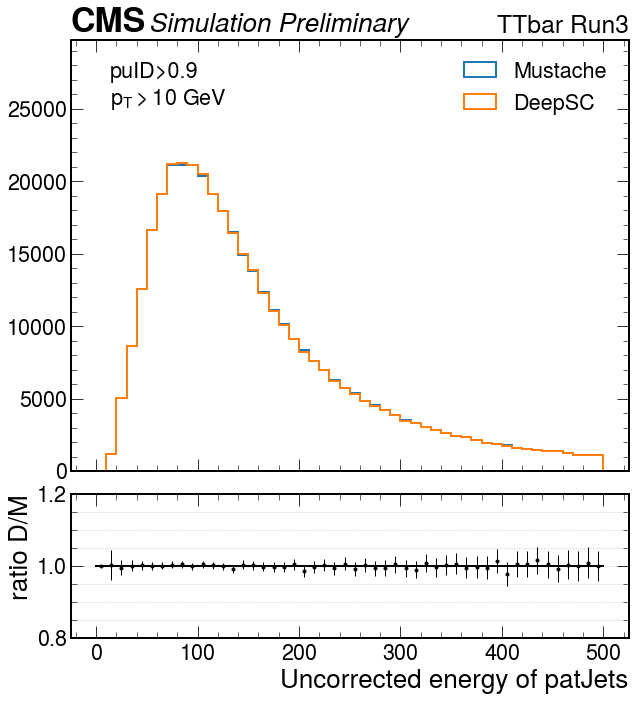

In [125]:
plot_comparison(ak.flatten(dfM.patJet_uncorrectedEnergy[(dfM.patJet_pt>10)&(dfM.patJet_puID>0.9)],axis=1), 
                ak.flatten(dfD.patJet_uncorrectedEnergy[(dfD.patJet_pt>10)&(dfD.patJet_puID>0.9)],axis=1),
                var=f"patjet_energy_uncorr", label="Uncorrected energy of patJets",
                text="puID>0.9\n$p_T>10$ GeV", texty=0.85,                
                output_folder=output_folder,
                bins=50, xrange=(0,500))

B: 363318.0
A. 363308.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


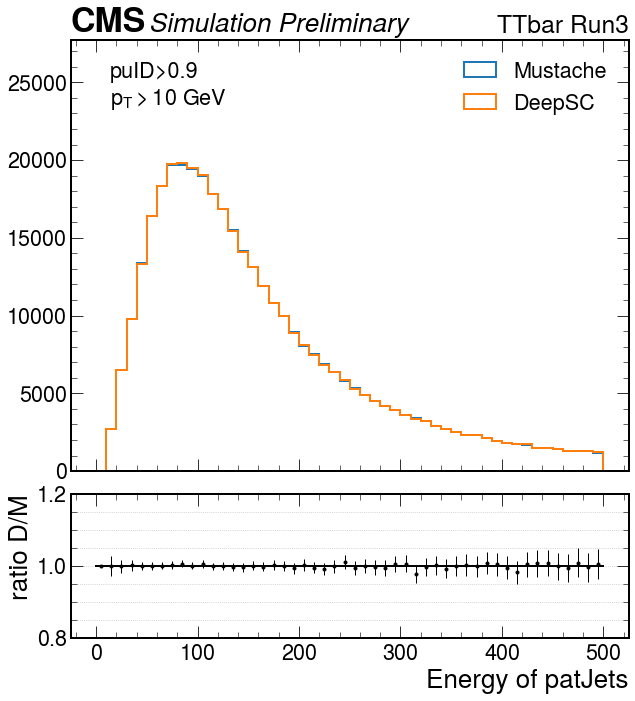

In [126]:
plot_comparison(ak.flatten(dfM.patJet_energy[(dfM.patJet_pt>10)&(dfM.patJet_puID>0.9)],axis=1), 
                ak.flatten(dfD.patJet_energy[(dfD.patJet_pt>10)&(dfD.patJet_puID>0.9)],axis=1),
                var=f"patjet_energy", label="Energy of patJets",
                text="puID>0.9\n$p_T>10$ GeV", texty=0.85,                
                output_folder=output_folder,
                bins=50, xrange=(0,500))

B: 385523.0
A. 385296.0


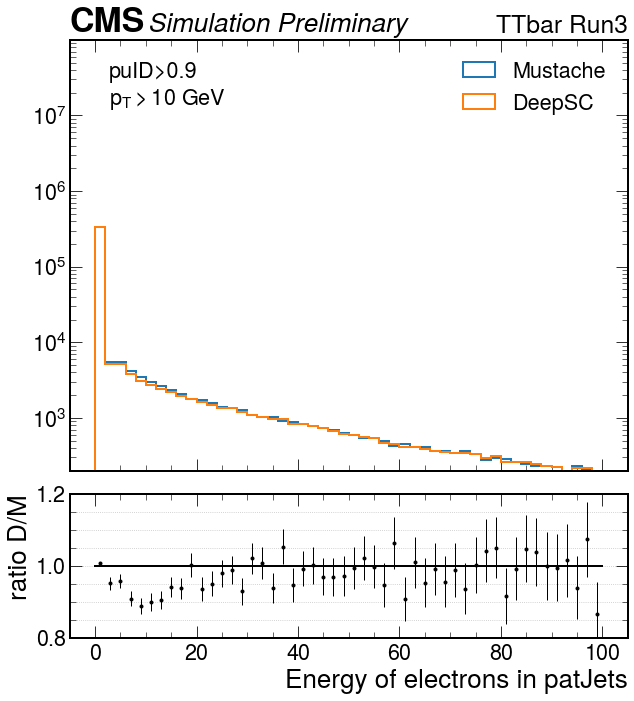

In [127]:
plot_comparison(ak.flatten(dfM.patJet_electronEnergy[(dfM.patJet_pt>10)&(dfM.patJet_puID>0.9)],axis=1), 
                ak.flatten(dfD.patJet_electronEnergy[(dfD.patJet_pt>10)&(dfD.patJet_puID>0.9)],axis=1),
                var=f"patjet_electron_energy", label="Energy of electrons in patJets",
                text="puID>0.9\n$p_T>10$ GeV", texty=0.85,                
                output_folder=output_folder, ylog=True,
                bins=50, xrange=(0,100))

B: 392641.0
A. 392634.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


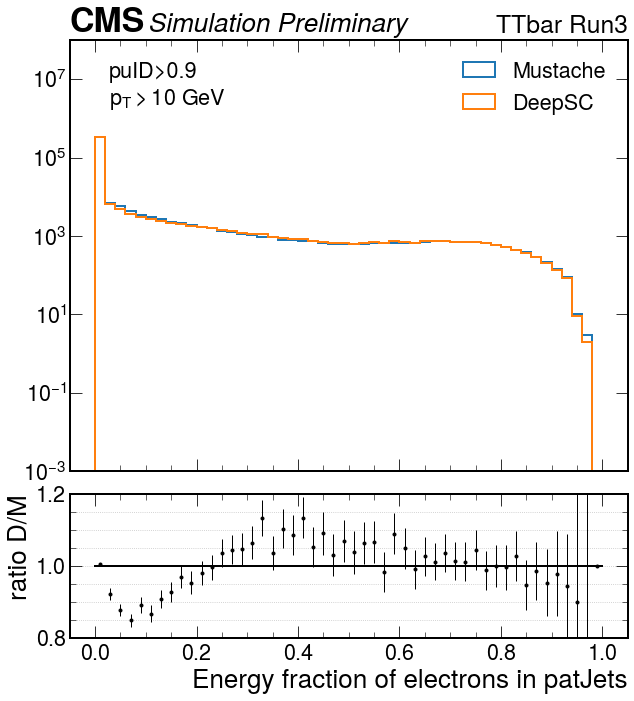

In [129]:
plot_comparison(ak.flatten(dfM.patJet_electronEnergyFraction[(dfM.patJet_pt>10)&(dfM.patJet_puID>0.9)],axis=1), 
                ak.flatten(dfD.patJet_electronEnergyFraction[(dfD.patJet_pt>10)&(dfD.patJet_puID>0.9)],axis=1),
                var=f"patjet_electron_energy_fraction", label="Energy fraction of electrons in patJets",
                text="puID>0.9\n$p_T>10$ GeV", texty=0.85,                
                output_folder=output_folder, ylog=True,
                bins=50, xrange=(0,1))

B: 939965.0
A. 940098.0


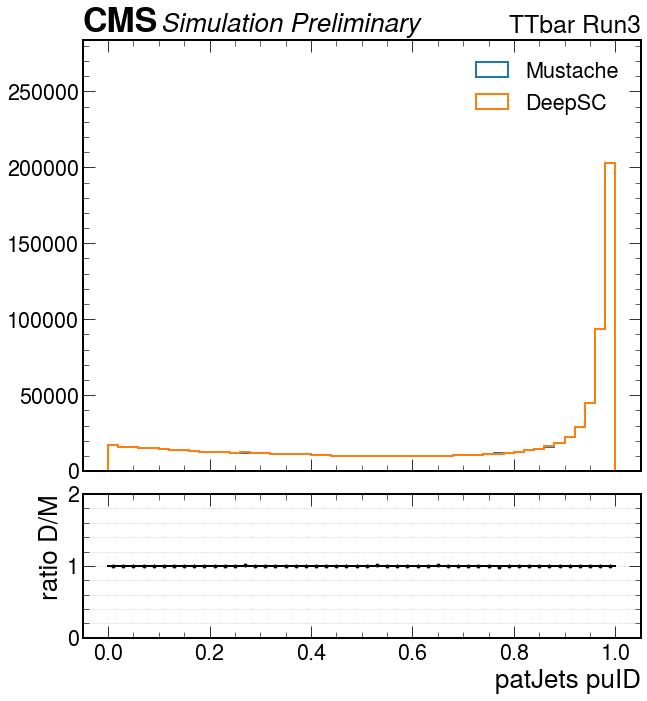

In [130]:
plot_comparison(ak.flatten(dfM.patJet_puID,axis=1), 
                ak.flatten(dfD.patJet_puID,axis=1),
                var=f"patJet_puid", label="patJets puID",
                output_folder=output_folder,
                bins=50, xrange=(0,1), ratio_lim=(0,2))

# Count the number of rechits per cluster in each supercluster

Plot for the evaluation in CMSSW

B: 99999.0
A. 99999.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: divide by zero encountered in true_divide
  A/B,
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


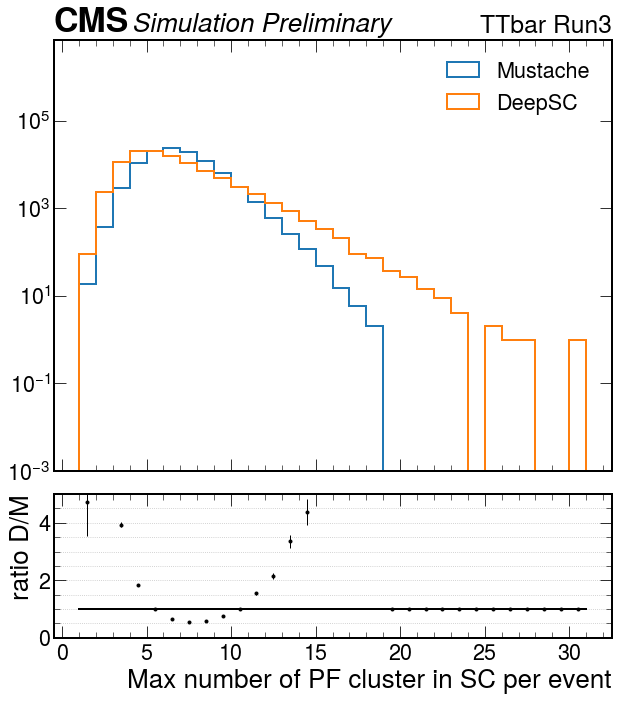

In [132]:
plot_comparison(ak.max(dfM.superCluster_nPFClusters, axis=1),
                ak.max(dfD.superCluster_nPFClusters, axis=1),
                var=f"nMax_cls_inSC_perevent", label="Max number of PF cluster in SC per event",
                output_folder=output_folder, ylog=True,
                bins=30, xrange=(1,31), ratio_lim=(0,5))

B: 1820727.0
A. 1549631.0


/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:90: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: divide by zero encountered in true_divide
  A/B,
/tmp/ipykernel_521/4253691877.py:93: RuntimeWarning: invalid value encountered in true_divide
  A/B,


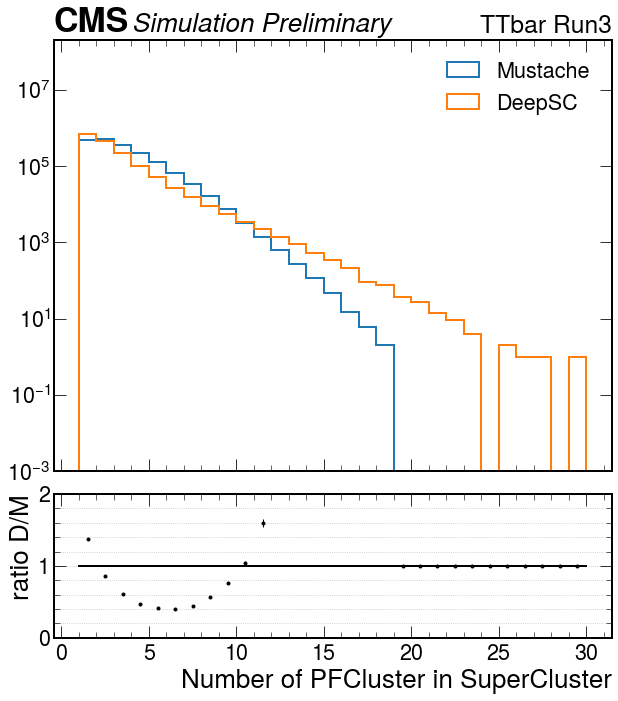

In [133]:
plot_comparison(ak.flatten(dfM.superCluster_nPFClusters,axis=1), 
                ak.flatten(dfD.superCluster_nPFClusters,axis=1),
                var=f"nCl_inSC", label="Number of PFCluster in SuperCluster",
                output_folder=output_folder, ylog=True,
                bins=29, xrange=(1,30), ratio_lim=(0,2))

A. 100000.0


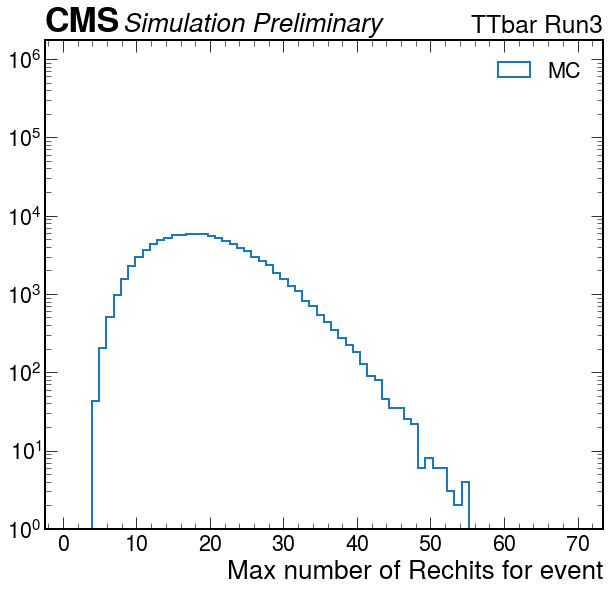

In [135]:
plot_hist(ak.max(dfM.pfCluster_nXtals,axis=1), 
                var=f"maxNxtlas_inCl", label="Max number of Rechits for event",
                output_folder=output_folder, ylog=True,
               legend="MC",
                bins=70, xrange=(1,70))

# Analysis of number of rechits and clusters in SC in the events

Extracted the windows from the ttbar MC, not only the selected clusters

In [5]:
! cp /eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTbar_14TeV_TuneCP5_Pythia8/RawDumper_DeepSC_12_5_0/ttbar_Run3_DeepSC_algoA_withRechit_withClEt.root .

In [11]:
dfR = uproot.lazy(["ttbar_Run3_DeepSC_algoA_withRechit_withClEt.root:recosimdumper/caloTree"])

In [8]:
dfR.fields

['nxtals', 'seed_et', 'cls_et']

In [3]:
dfR = uproot.open("ttbar_Run3_DeepSC_algoA_withRechit_withClEt.root:recosimdumper/caloTree")

In [4]:
data  = dfR["nxtals"].array()

Counting object by event or by window

In [5]:
data = dfR.nxtals

In [5]:
data = data[ak.num(data, axis=1)>0] ## at least 1 window

In [6]:
ncls = ak.num(data, axis=2)
nwind = ak.num(data, axis=1)
max_ncls_ev = ak.max(ncls, axis=1)
max_rec = ak.max(data, axis=2)
max_rec_ev = ak.max(max_rec, axis=1)

A. 100000.0


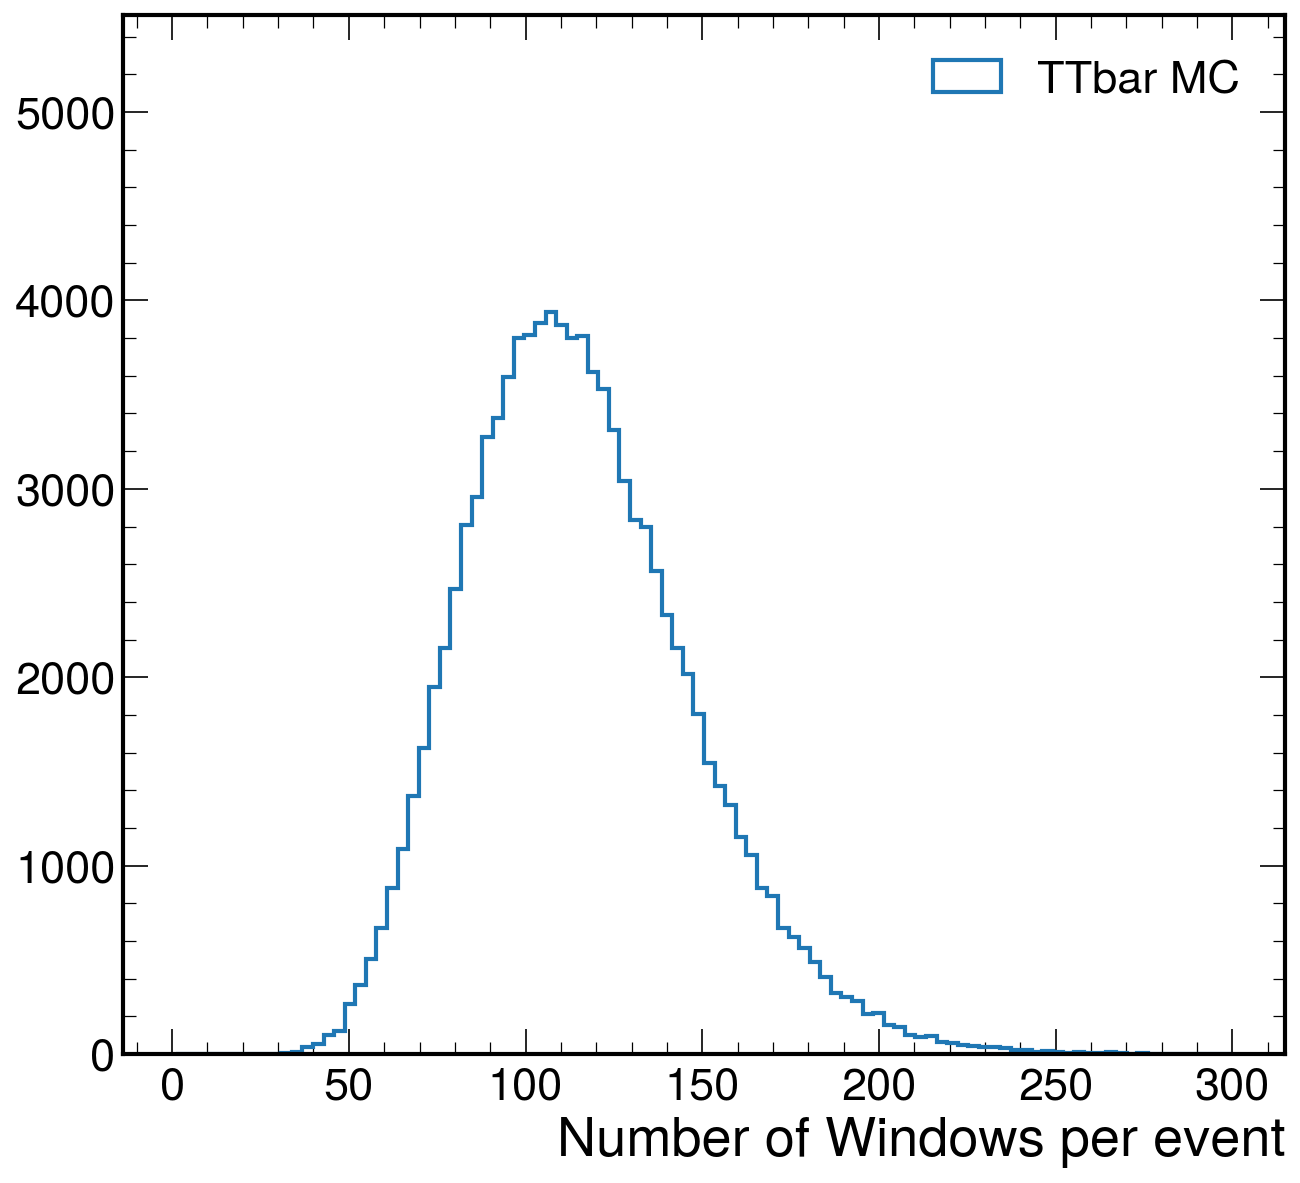

In [16]:
plot_hist(nwind,
        var=f"number_of_window_perevent", label="Number of Windows per event",
        output_folder=output_folder, 
       legend="TTbar MC", rlabel="14 TeV (Run 3)", 
        bins=100, xrange=(1,300), llabel="")

A. 99996.0


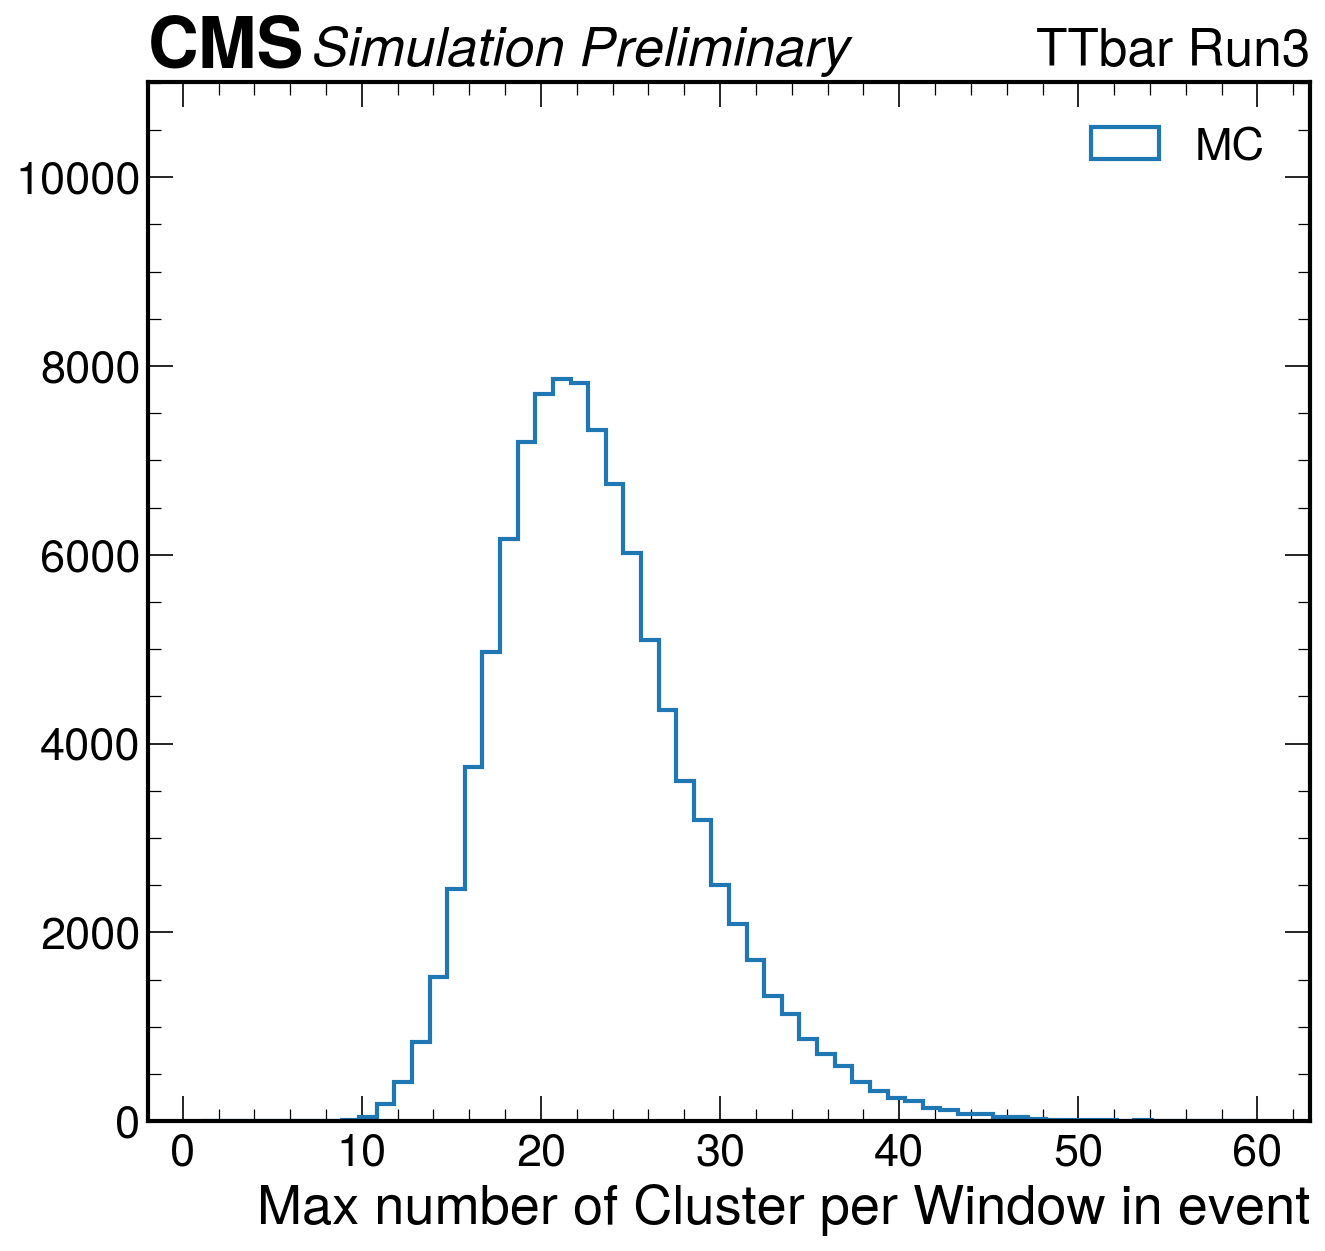

In [39]:
plot_hist(max_ncls_ev,
        var=f"maxnumber_of_cls_perSC_in_event", label="Max number of Cluster per Window in event",
        output_folder=output_folder,
       legend="MC",
        bins=60, xrange=(1,60))

A. 11523336.0


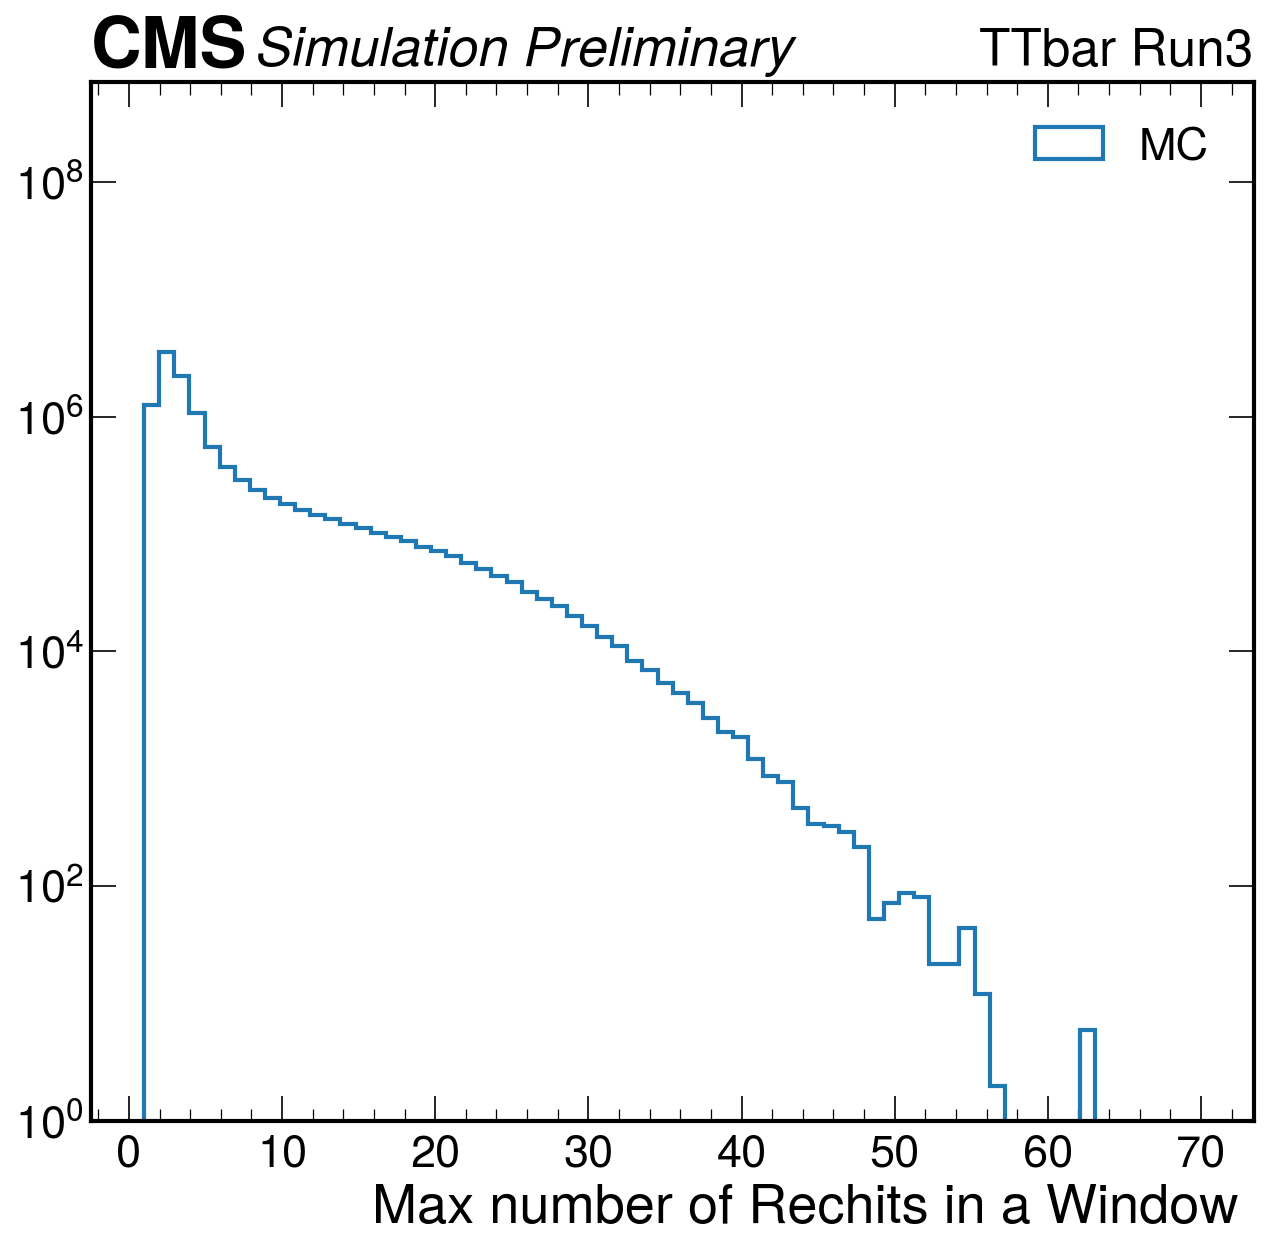

In [44]:
plot_hist(ak.flatten(max_rec), 
                var=f"max_rechits_in_window", label="Max number of Rechits in a Window ",
                output_folder=output_folder, ylog=True,
               legend="MC",
                bins=70, xrange=(1,70))

A. 100000.0


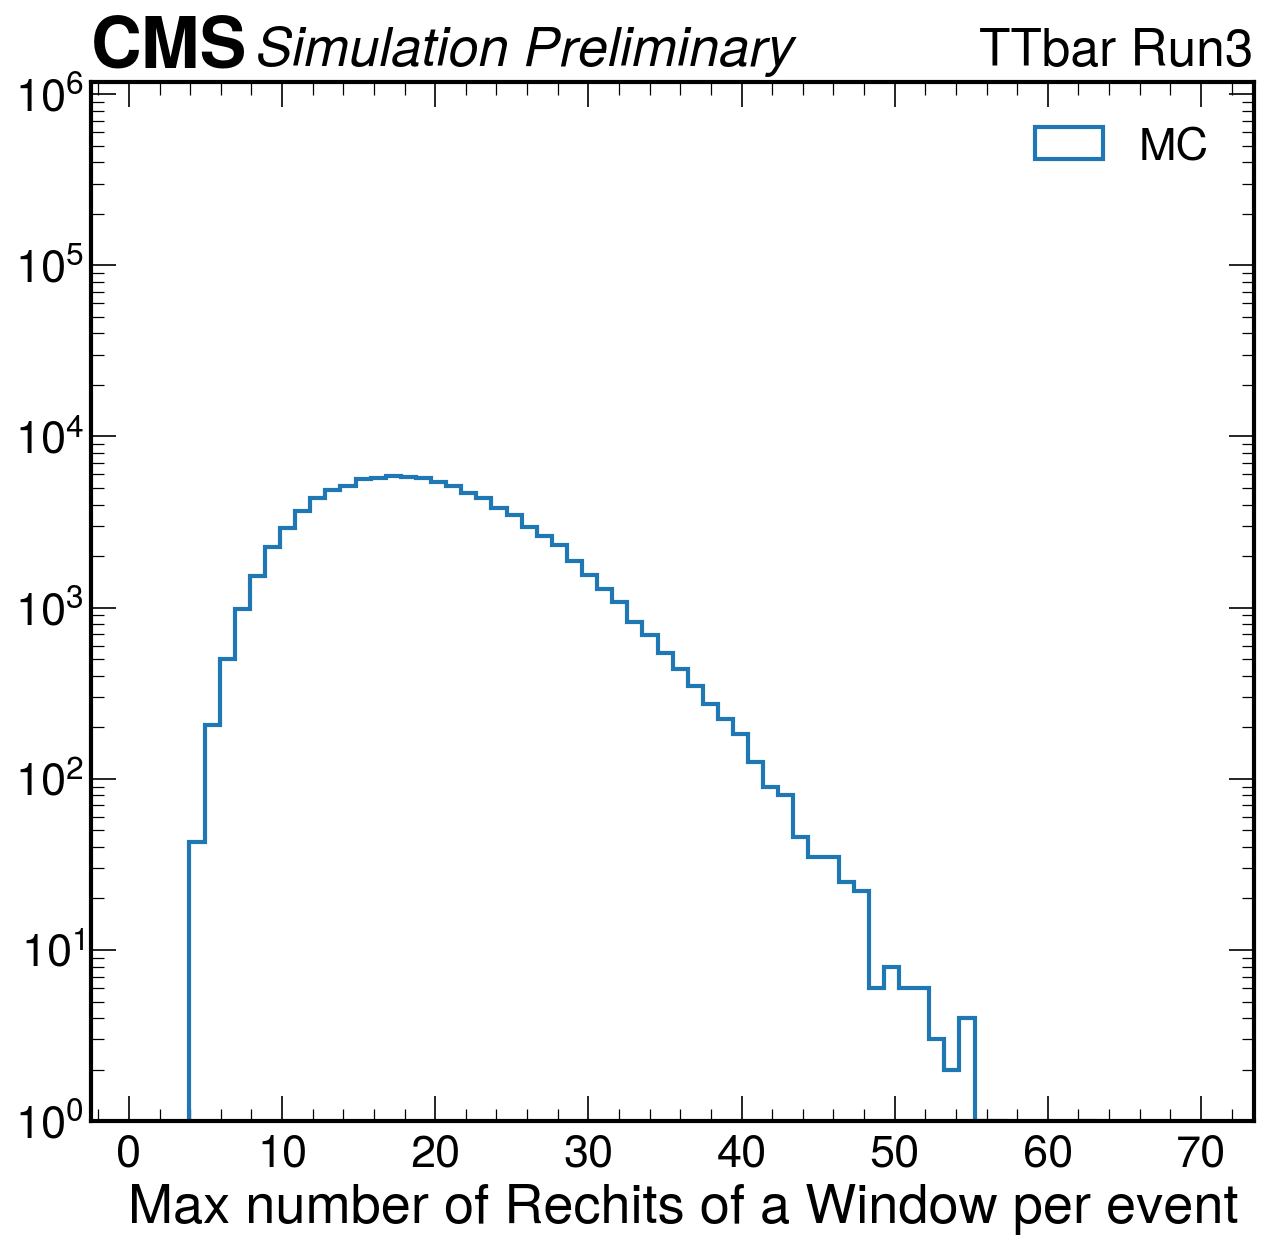

In [45]:
plot_hist(max_rec_ev,
                var=f"max_rechits_in_window_per_Event", label="Max number of Rechits of a Window per event ",
                output_folder=output_folder, ylog=True,
               legend="MC",
                bins=70, xrange=(1,70))

A. 11523103.0


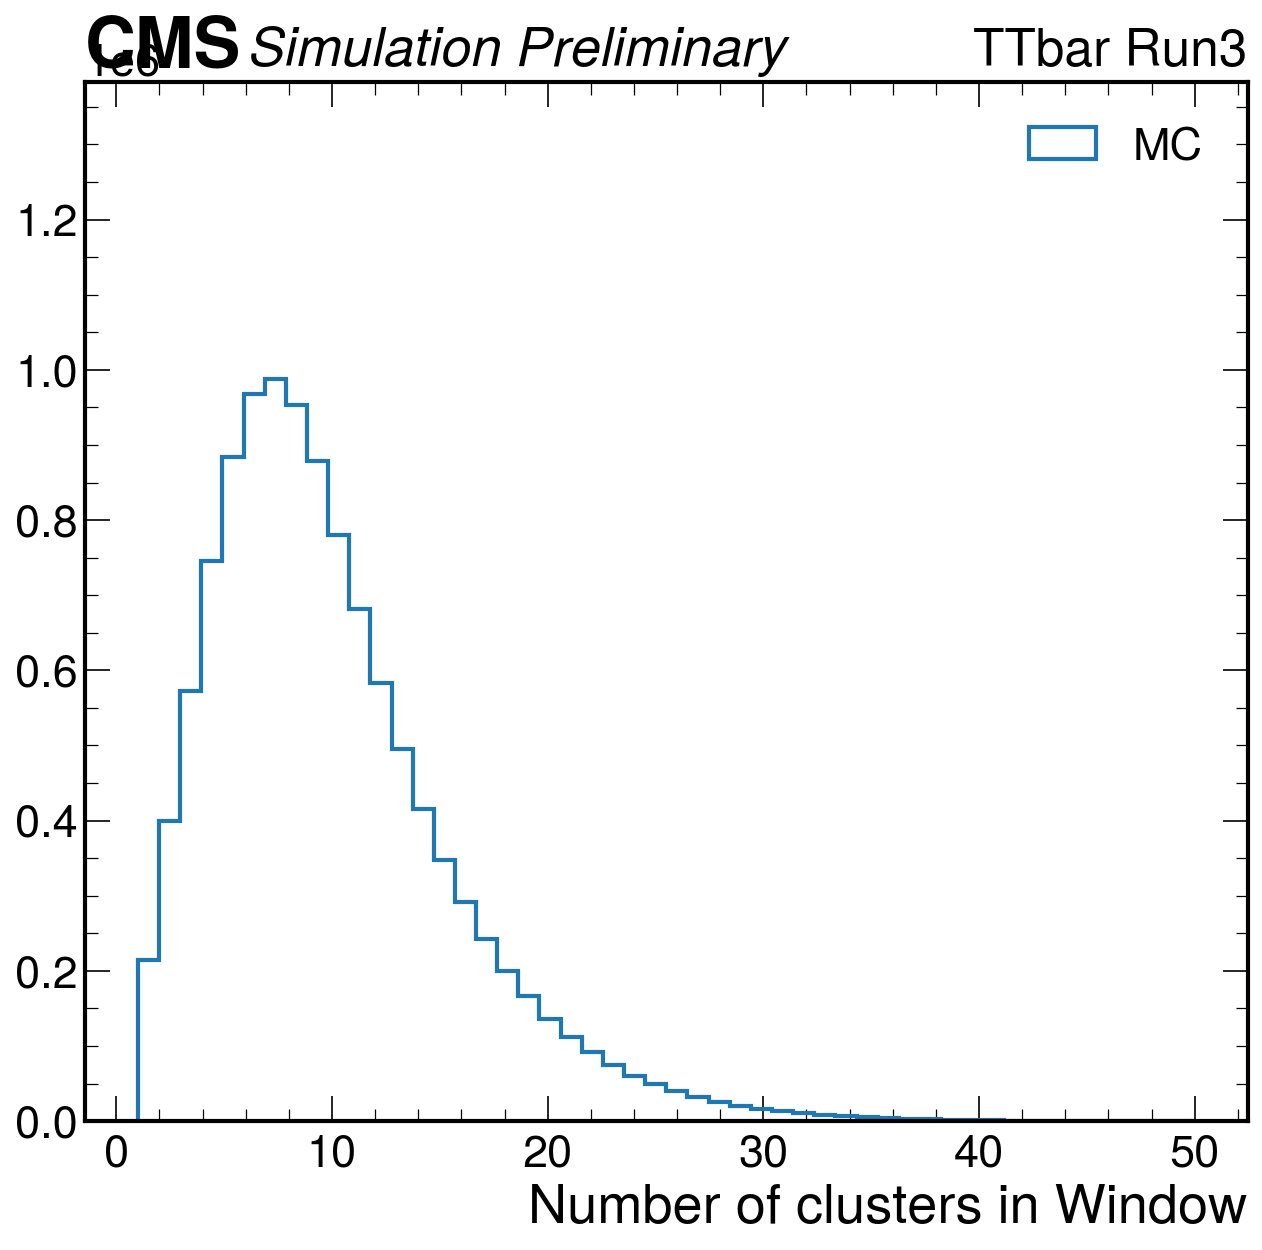

In [32]:
plot_hist(ak.flatten(ncls), 
                var=f"ncls_in_Window", label="Number of clusters in Window",
                output_folder=output_folder,
               legend="MC",
                bins=50, xrange=(1,50))

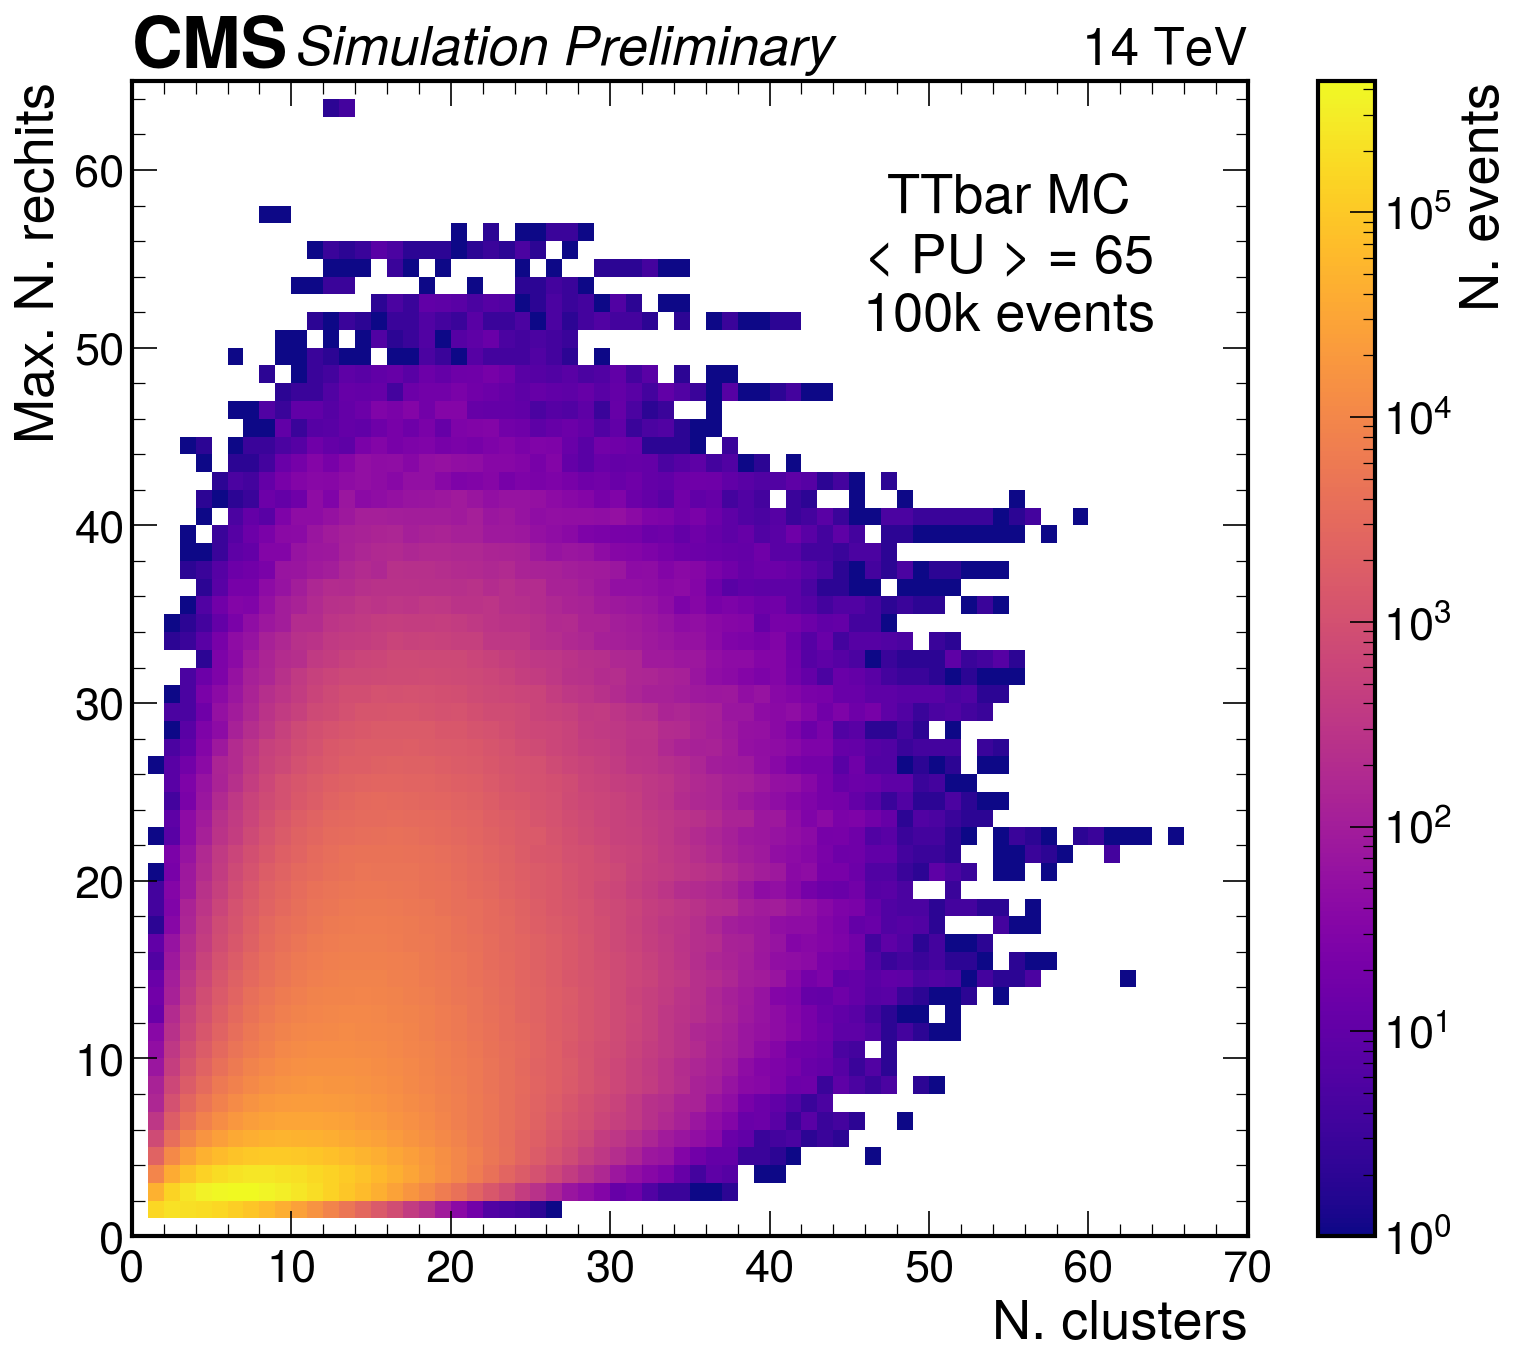

In [36]:
fig = plt.figure(figsize=(12,10), dpi=150)
ax = plt.gca()
counts,xbins,ybins,image = ax.hist2d(ak.to_numpy(ak.flatten(ncls)),
                                     ak.to_numpy(ak.flatten(max_rec)),
                                     norm=LogNorm(),
                                     cmap="plasma", bins=(70, 65), range=((0,70),(0,65)))

plt.colorbar(image, label="N. events")
ax.set_xlabel("N. clusters")
ax.set_ylabel("Max. N. rechits")
#ax.text(49,60, "N. Objects per window",  horizontalalignment="center")
ax.text(55, 51, "TTbar MC\n< PU > = 65\n100k events",  horizontalalignment="center")

hep.cms.label(llabel="Simulation Preliminary", rlabel="14 TeV", loc=0, ax=ax)
if output_folder!=None:
    var ="nclusters_nrechits_perwindow"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

/tmp/ipykernel_12741/2913545166.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  I = ax.contourf(np.arange(1, 71), np.arange(1,71), counts,  norm=LogNorm(),
/tmp/ipykernel_12741/2913545166.py:6: UserWarning: linewidths is ignored by contourf
  I = ax.contourf(np.arange(1, 71), np.arange(1,71), counts,  norm=LogNorm(),


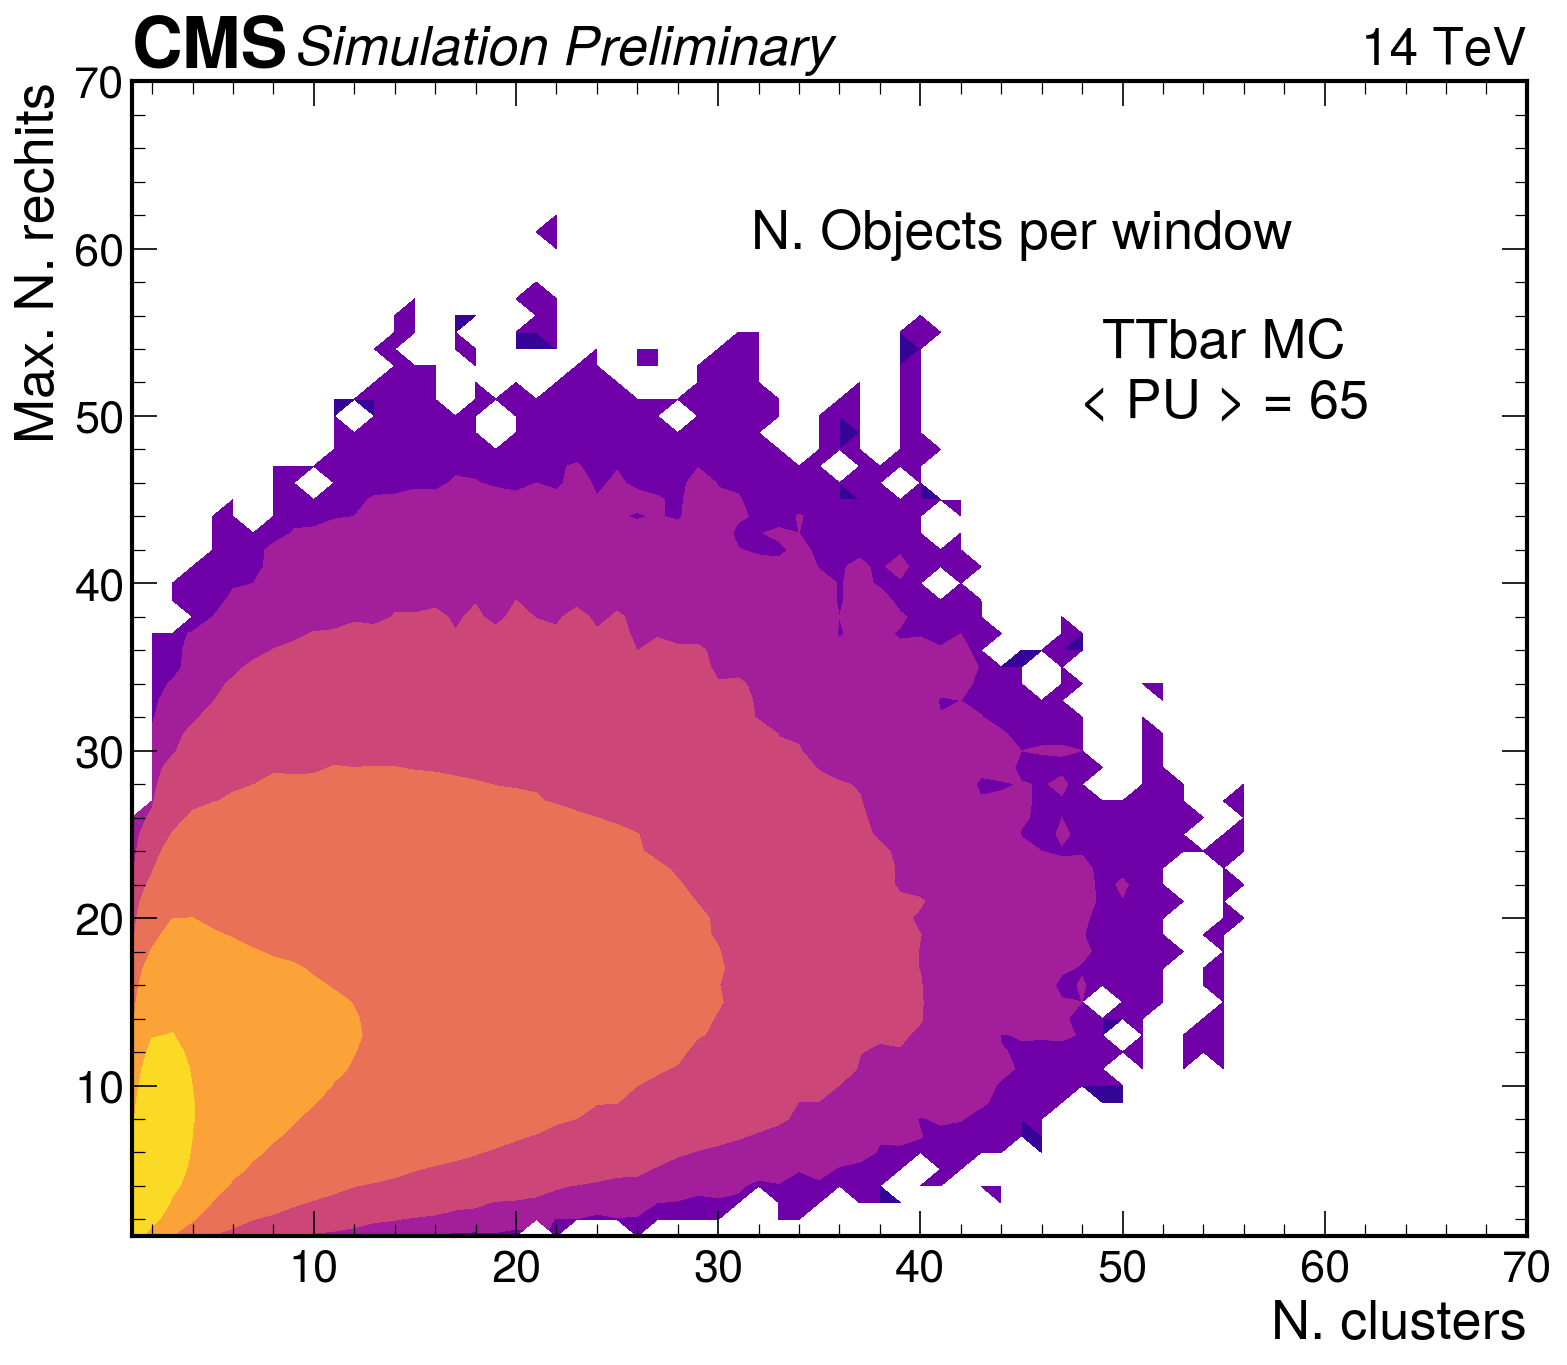

In [223]:
fig = plt.figure(figsize=(12,10), dpi=150)
ax = plt.gca()
counts, _,_ = np.histogram2d(ak.to_numpy(ak.flatten(ncls)),
                                     ak.to_numpy(ak.flatten(max_rec)),bins=(70, 70), range=((1,71),(1,71)) )

I = ax.contourf(np.arange(1, 71), np.arange(1,71), counts,  norm=LogNorm(),
             linestyles="dashed",
              cmap="plasma", linewidths=2)

plt.colorbar(image)
ax.set_xlabel("N. clusters")
ax.set_ylabel("Max. N. rechits")
ax.text(45,60, "N. Objects per window",  horizontalalignment="center")
ax.text(55, 50, "TTbar MC\n< PU > = 65",  horizontalalignment="center")

hep.cms.label(llabel="Simulation Preliminary", rlabel="14 TeV", loc=0, ax=ax)
if output_folder!=None:
    var ="nclusters_nrechits_perwindow"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

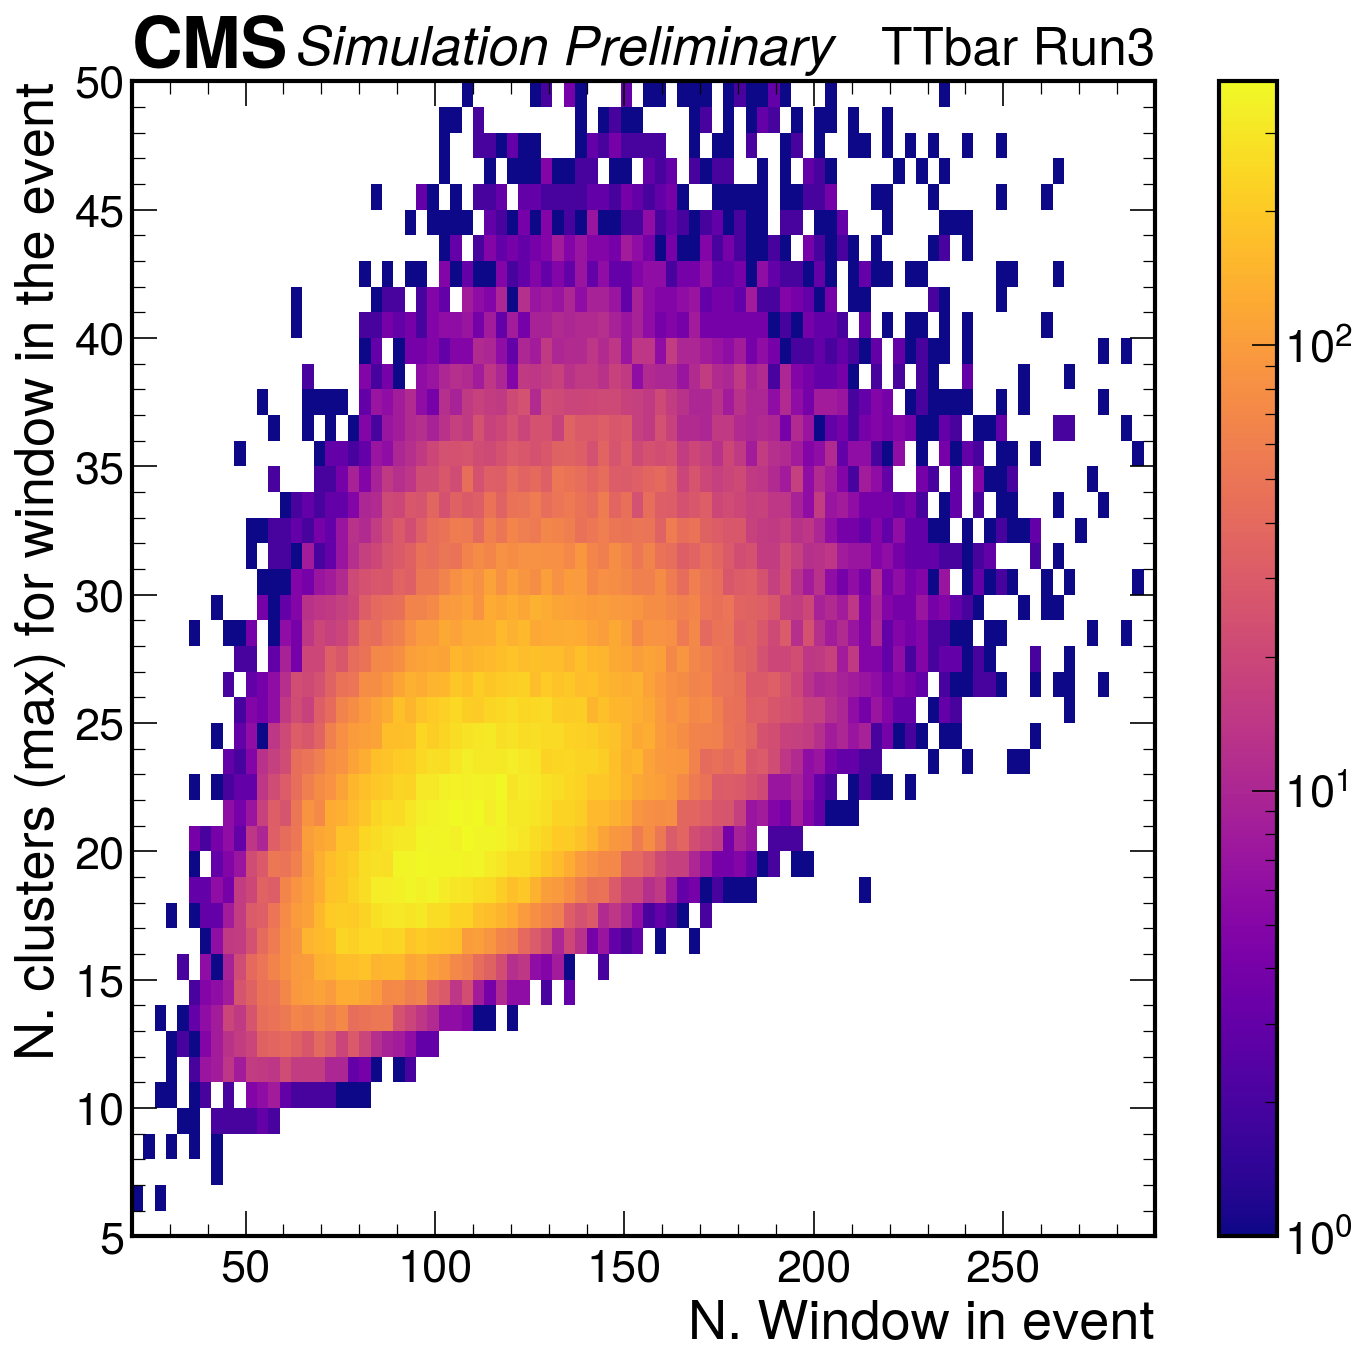

In [52]:
fig = plt.figure(figsize=(11,10), dpi=150)
ax = plt.gca()
counts,xbins,ybins,image = ax.hist2d(ak.to_numpy(nwind), 
                                     ak.to_numpy(max_ncls_ev),
                                     norm=LogNorm(),
                                      cmap="plasma", bins=(90, 45), range=((20,290),(5,50)))

plt.colorbar(image)
ax.set_xlabel("N. Window in event")
ax.set_ylabel("N. clusters (max) for window in the event")

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="nwind_nclsmax_perevent"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

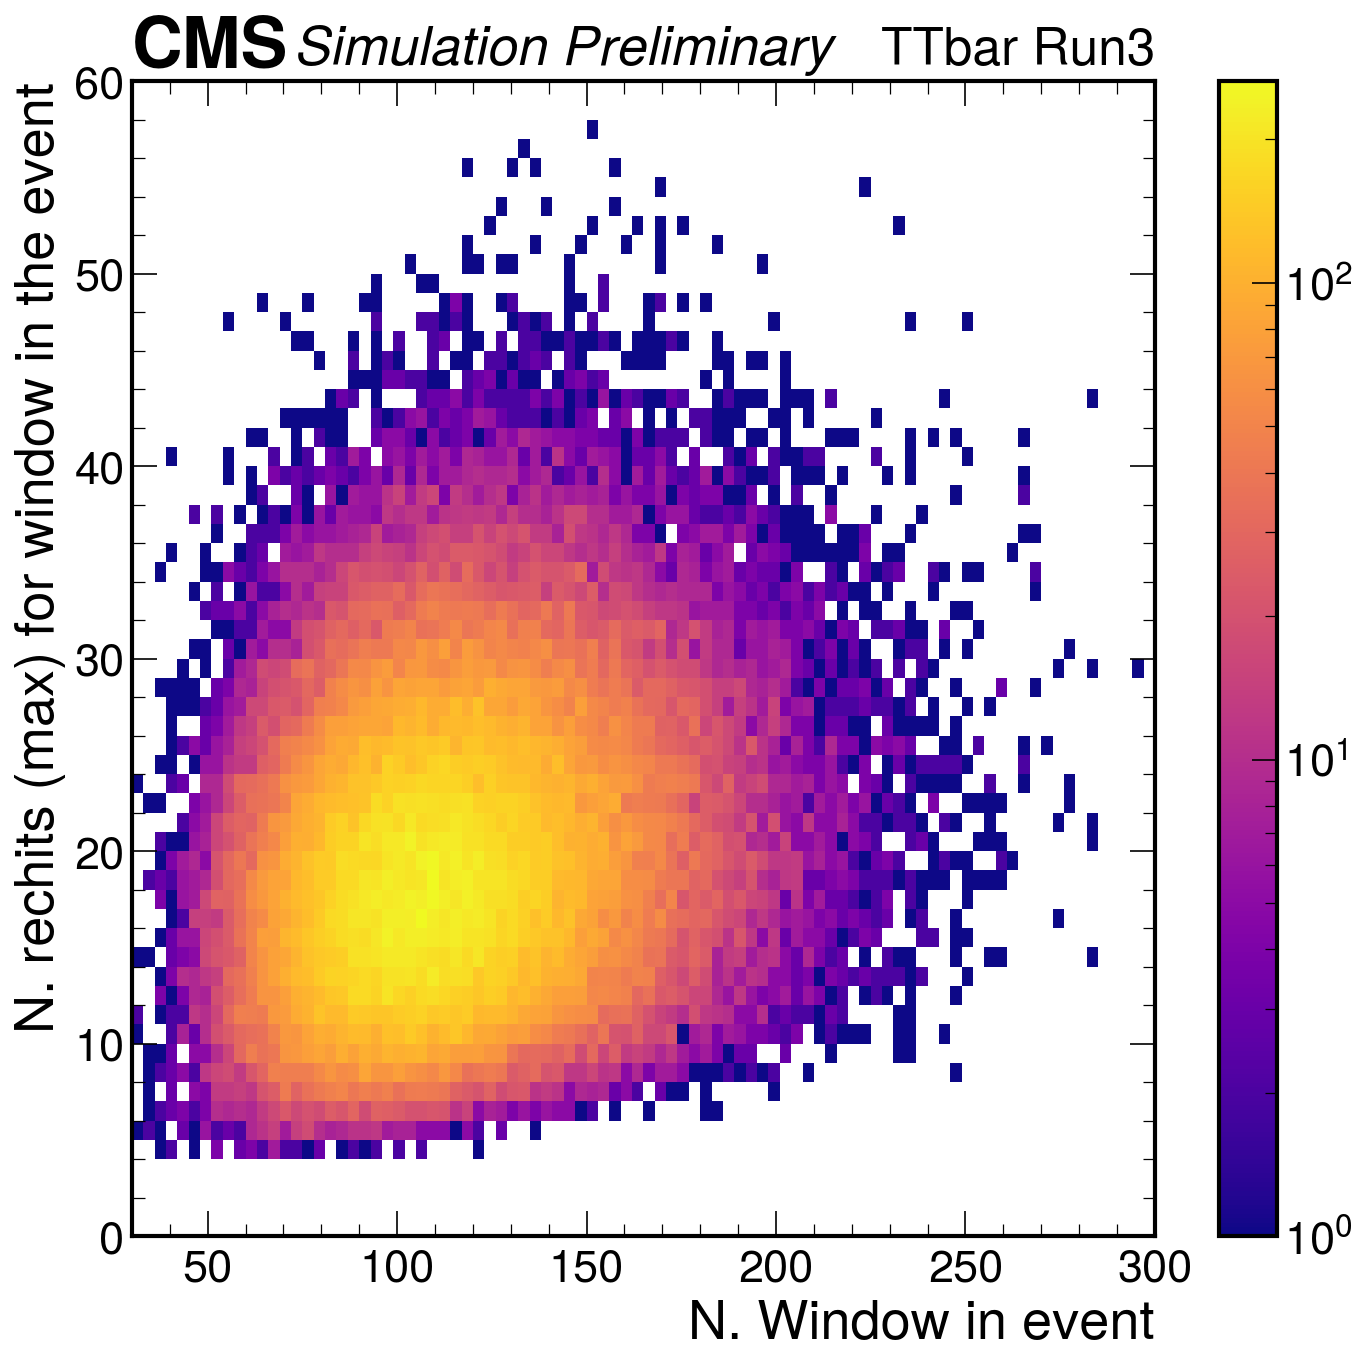

In [55]:
fig = plt.figure(figsize=(11,10), dpi=150)
ax = plt.gca()
counts,xbins,ybins,image = ax.hist2d(ak.to_numpy(nwind),
                                     ak.to_numpy(max_rec_ev),
                                     norm=LogNorm(),
                                      cmap="plasma", bins=(90, 60), range=((30,300),(0,60)))

plt.colorbar(image)
ax.set_xlabel("N. Window in event")
ax.set_ylabel("N. rechits (max) for window in the event")

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="nwind_nmaxrechit_perevent"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

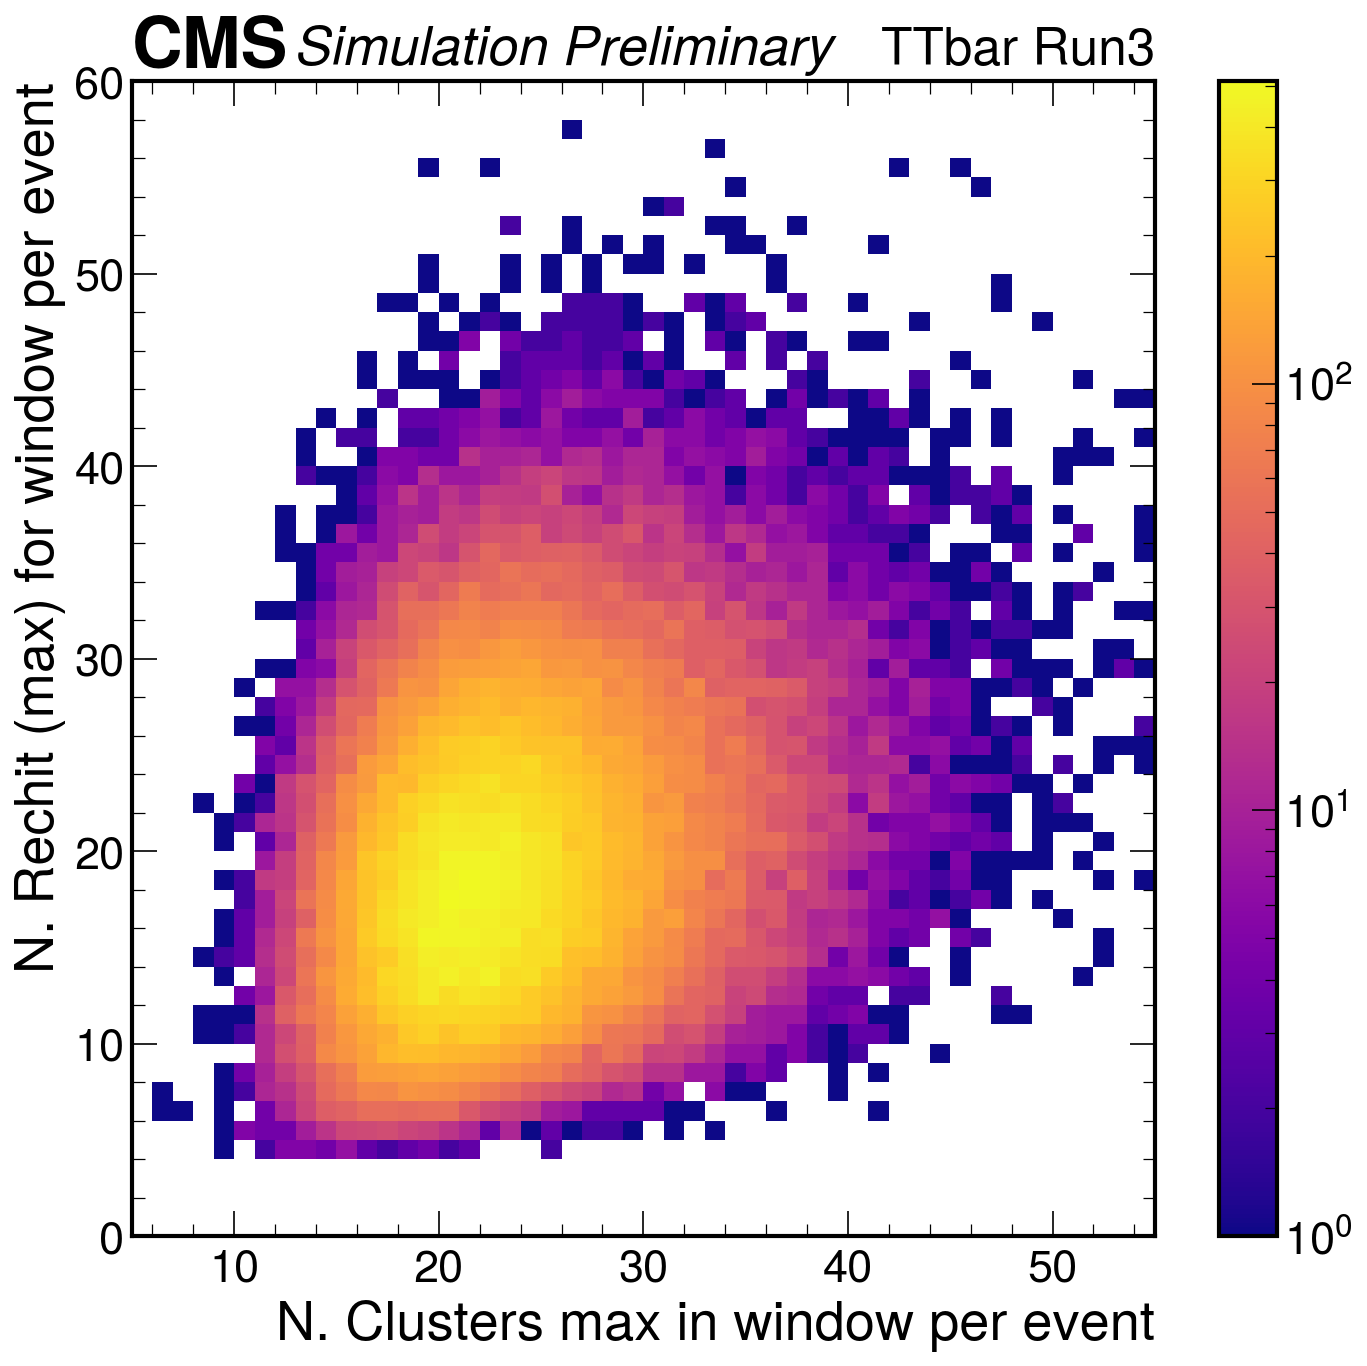

In [58]:
fig = plt.figure(figsize=(11,10), dpi=150)
ax = plt.gca()
counts,xbins,ybins,image = plt.hist2d(ak.to_numpy(max_ncls_ev),
                                      ak.to_numpy(max_rec_ev),
                                      norm=LogNorm(),
                                      cmap="plasma", bins=(50, 60), range=((5,55),(0,60)))

plt.colorbar(image)
ax.set_xlabel("N. Clusters max in window per event")
ax.set_ylabel("N. Rechit (max) for window per event")

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="ncls_nmaxrechit_perevent"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

### Analyze the cumulative distribution

In [19]:
count_rec, bins = np.histogram(ak.flatten(max_rec), bins=np.arange(0,60))
count_cls, bins = np.histogram(ak.flatten(ncls), bins=np.arange(0,60))
count_wind, bins = np.histogram(nwind, bins=np.arange(0,60))

In [20]:
def reverse_cumulative(c):
    return np.flip(np.cumsum(np.flip(c)))/ np.sum(c)

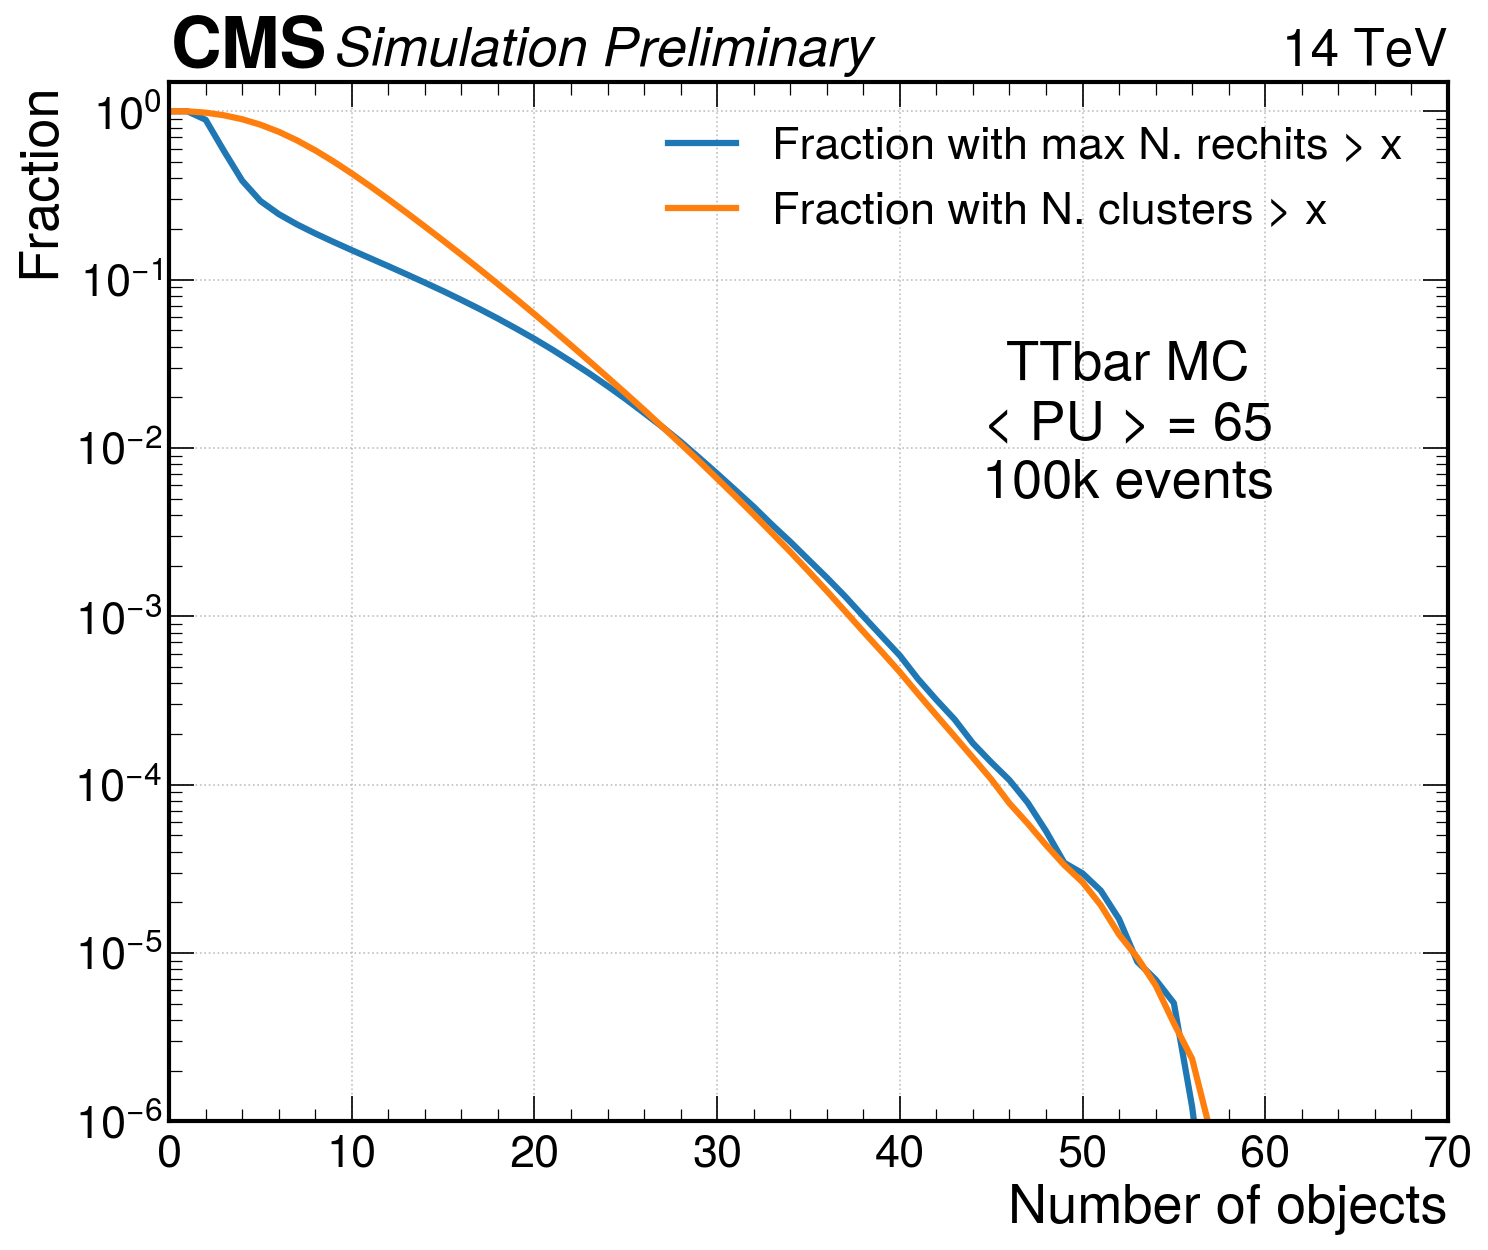

In [46]:
fig = plt.figure(figsize=(11,9), dpi=150)
ax = plt.gca()
ax.plot(reverse_cumulative(count_rec), linewidth=3, label="Fraction with max N. rechits > x")
ax.plot(reverse_cumulative(count_cls), linewidth=3, label="Fraction with N. clusters > x")
#ax.plot(reverse_cumulative(count_wind), linewidth=3, label="% events with N. windows > x", linestyle="dashed")
ax.set_yscale("log")
ax.set_xlabel("Number of objects")
ax.set_ylabel("Fraction")
ax.set_ylim(1e-6, 1.5)
ax.set_xlim(0, 70)
ax.grid()
ax.legend()

hep.cms.label(llabel="Simulation Preliminary", rlabel="14 TeV", loc=0, ax=ax)
ax.text(0.75, 0.6, "TTbar MC\n< PU > = 65\n100k events", transform=ax.transAxes, horizontalalignment="center")

if output_folder!=None:
    var ="cumulative_nrechit_ncls_perwindow"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

Now we compute the average fraction of windows that needs to the evaluated with the large model after 
the application of the N rechit and N clusters cuts

In [68]:
len(list(range(1,61,2)))

30

In [80]:
fraction_small = np.zeros((60,60))
n_wind_toeval_small = np.zeros((60,60))
for irec in range(1, 61):
    mask_rec = max_rec<=irec
    dcut = data[mask_rec]
    for icl in range(1,61):
        print(irec,icl, end="| ")
        #nwind_clcut = ak.num(dcut[(ak.num(dcut, axis=2)<=icl)], axis=1)
        nwind_clcut = ak.sum(ak.num(dcut, axis=2)<=icl, axis=1)
        n_wind_toeval_small[icl-1, irec-1] = ak.mean(nwind_clcut)
        fraction_small[icl-1, irec-1] = ak.mean(nwind_clcut/nwind)

1 1| 1 2| 1 3| 1 4| 1 5| 1 6| 1 7| 1 8| 1 9| 1 10| 1 11| 1 12| 1 13| 1 14| 1 15| 1 16| 1 17| 1 18| 1 19| 1 20| 1 21| 1 22| 1 23| 1 24| 1 25| 1 26| 1 27| 1 28| 1 29| 1 30| 1 31| 1 32| 1 33| 1 34| 1 35| 1 36| 1 37| 1 38| 1 39| 1 40| 1 41| 1 42| 1 43| 1 44| 1 45| 1 46| 1 47| 1 48| 1 49| 1 50| 1 51| 1 52| 1 53| 1 54| 1 55| 1 56| 1 57| 1 58| 1 59| 1 60| 2 1| 2 2| 2 3| 2 4| 2 5| 2 6| 2 7| 2 8| 2 9| 2 10| 2 11| 2 12| 2 13| 2 14| 2 15| 2 16| 2 17| 2 18| 2 19| 2 20| 2 21| 2 22| 2 23| 2 24| 2 25| 2 26| 2 27| 2 28| 2 29| 2 30| 2 31| 2 32| 2 33| 2 34| 2 35| 2 36| 2 37| 2 38| 2 39| 2 40| 2 41| 2 42| 2 43| 2 44| 2 45| 2 46| 2 47| 2 48| 2 49| 2 50| 2 51| 2 52| 2 53| 2 54| 2 55| 2 56| 2 57| 2 58| 2 59| 2 60| 3 1| 3 2| 3 3| 3 4| 3 5| 3 6| 3 7| 3 8| 3 9| 3 10| 3 11| 3 12| 3 13| 3 14| 3 15| 3 16| 3 17| 3 18| 3 19| 3 20| 3 21| 3 22| 3 23| 3 24| 3 25| 3 26| 3 27| 3 28| 3 29| 3 30| 3 31| 3 32| 3 33| 3 34| 3 35| 3 36| 3 37| 3 38| 3 39| 3 40| 3 41| 3 42| 3 43| 3 44| 3 45| 3 46| 3 47| 3 48| 3 49| 3 50| 3 51| 3

In [86]:
np.save( output_folder + "/efficiency_data.npz", fraction_small)

In [23]:
from matplotlib import ticker, cm

In [24]:
fraction_small = np.load(output_folder + "/efficiency_data.npz.npy")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,10), dpi=150)

#I = ax.imshow(1- fraction_small.T,origin="lower", cmap="plasma", norm=LogNorm(vmax=1, vmin=1e-6),
              # aspect="auto")

#ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 60,5))
ax.set_yticks(np.arange(0, 60,5))
ax.set_xticklabels(np.arange(0,60,5))
ax.set_yticklabels(np.arange(0,60,5))
ax.minorticks_off()

I = ax.contourf(np.arange(1, 61), np.arange(1,61), 1-fraction_small, norm=LogNorm(vmax=1, vmin=1e-7), 
             linestyles="dashed", #levels=[1e-7, 1e-6,1e-5,1e-4,1e-3,5e-3, 1e-2, 5e-2, 1e-1, 0.5, 0.75, 1],
           cmap="plasma", linewidths=2)

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

plt.colorbar(I, ax=ax, label="Average fraction", format=ticker.FuncFormatter(fmt))

ax.set_xlabel("N. Cluster")
ax.set_ylabel("Max N. Rechits")
ax.text(0.1, 0.15, "Average fraction \nwith $N_{clusters}> x$ or $N_{max rechits} > y$", 
       transform=ax.transAxes)

hep.cms.label(llabel="Simulation Preliminary", rlabel="14 TeV", loc=0, ax=ax)
ax.text(13,47, "TTbar MC\n< PU > = 65\n100k events", horizontalalignment="center")

ax.scatter(15, 20, s=600, c="red", marker=(5, 1))
ax.text(7, 23, "WP ($N_{cl}=15$, $N_{hits}=20$)", fontsize=14)

if output_folder!=None:
    var ="cumulative_perevent_window_efficiency"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

/tmp/ipykernel_30436/2112871939.py:13: UserWarning: linewidths is ignored by contourf
  I = ax.contourf(np.arange(1, 61), np.arange(1,61), 1-fraction_small, norm=LogNorm(vmax=1, vmin=1e-7),


/tmp/ipykernel_30436/453305969.py:13: UserWarning: linewidths is ignored by contourf
  I = ax.contourf(np.arange(1, 61), np.arange(1,61), 1-fraction_small, norm=LogNorm(vmax=1, vmin=1e-7),


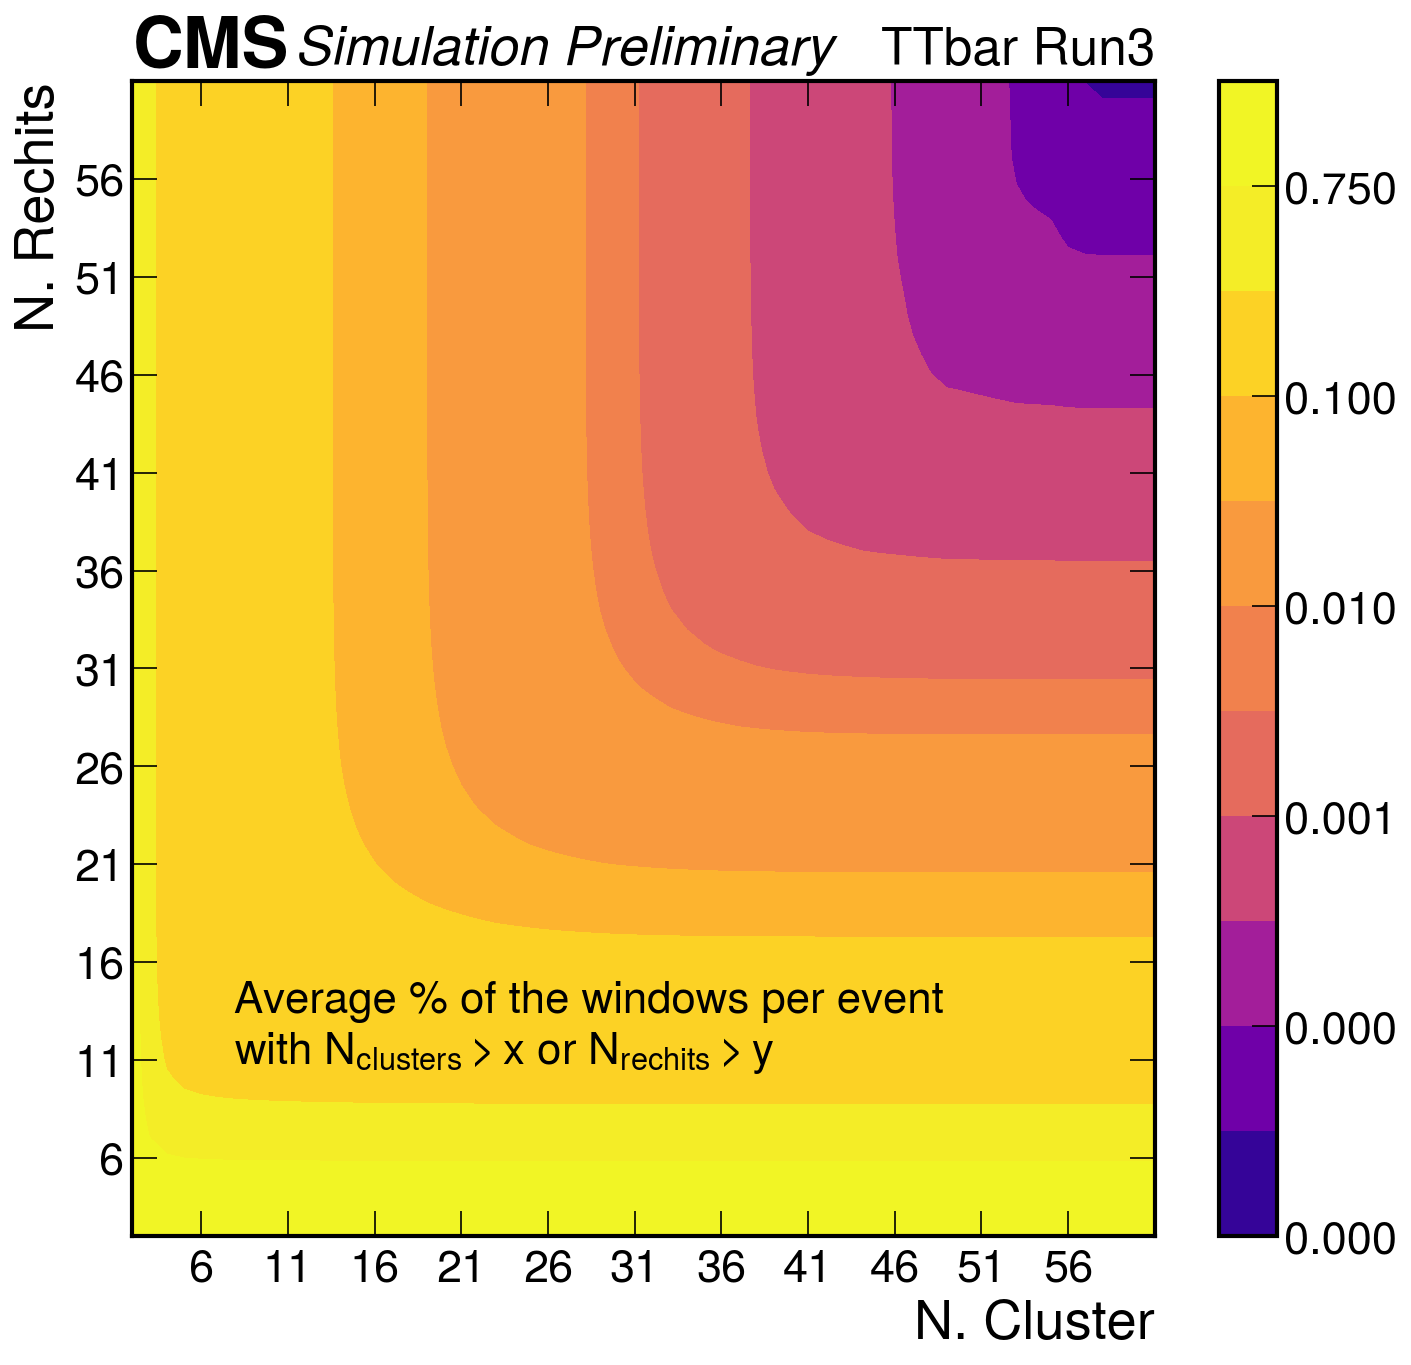

In [41]:
fig, ax = plt.subplots(1,1, figsize=(11,10), dpi=150)

#I = ax.imshow(1- fraction_small.T,origin="lower", cmap="plasma", norm=LogNorm(vmax=1, vmin=1e-6),
              # aspect="auto")

#ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 60,5))
ax.set_yticks(np.arange(0, 60,5))
ax.set_xticklabels(np.arange(1,61,5))
ax.set_yticklabels(np.arange(1,61,5))
ax.minorticks_off()

I = ax.contourf(np.arange(1, 61), np.arange(1,61), 1-fraction_small, norm=LogNorm(vmax=1, vmin=1e-7), 
            levels=[1e-7, 1e-6,1e-5,1e-4,1e-3,5e-3, 1e-2, 5e-2, 1e-1, 0.5, 0.75, 1], linestyles="dashed",
           cmap="plasma", linewidths=2)
plt.colorbar(I, ax=ax)

ax.set_xlabel("N. Cluster")
ax.set_ylabel("N. Rechits")
ax.text(0.1, 0.15, "Average % of the windows per event\nwith $N_{clusters}> x$ or $N_{rechits} > y$", 
       transform=ax.transAxes, fontsize=21)

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="cumulative_perevent_window_efficiency"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")

In [ ]:
mask_rec = max_rec<=irec
    dcut = data[mask_rec]

<Array [107, 107, 89, 134, ... 107, 138, 150] type='100000 * int64'>

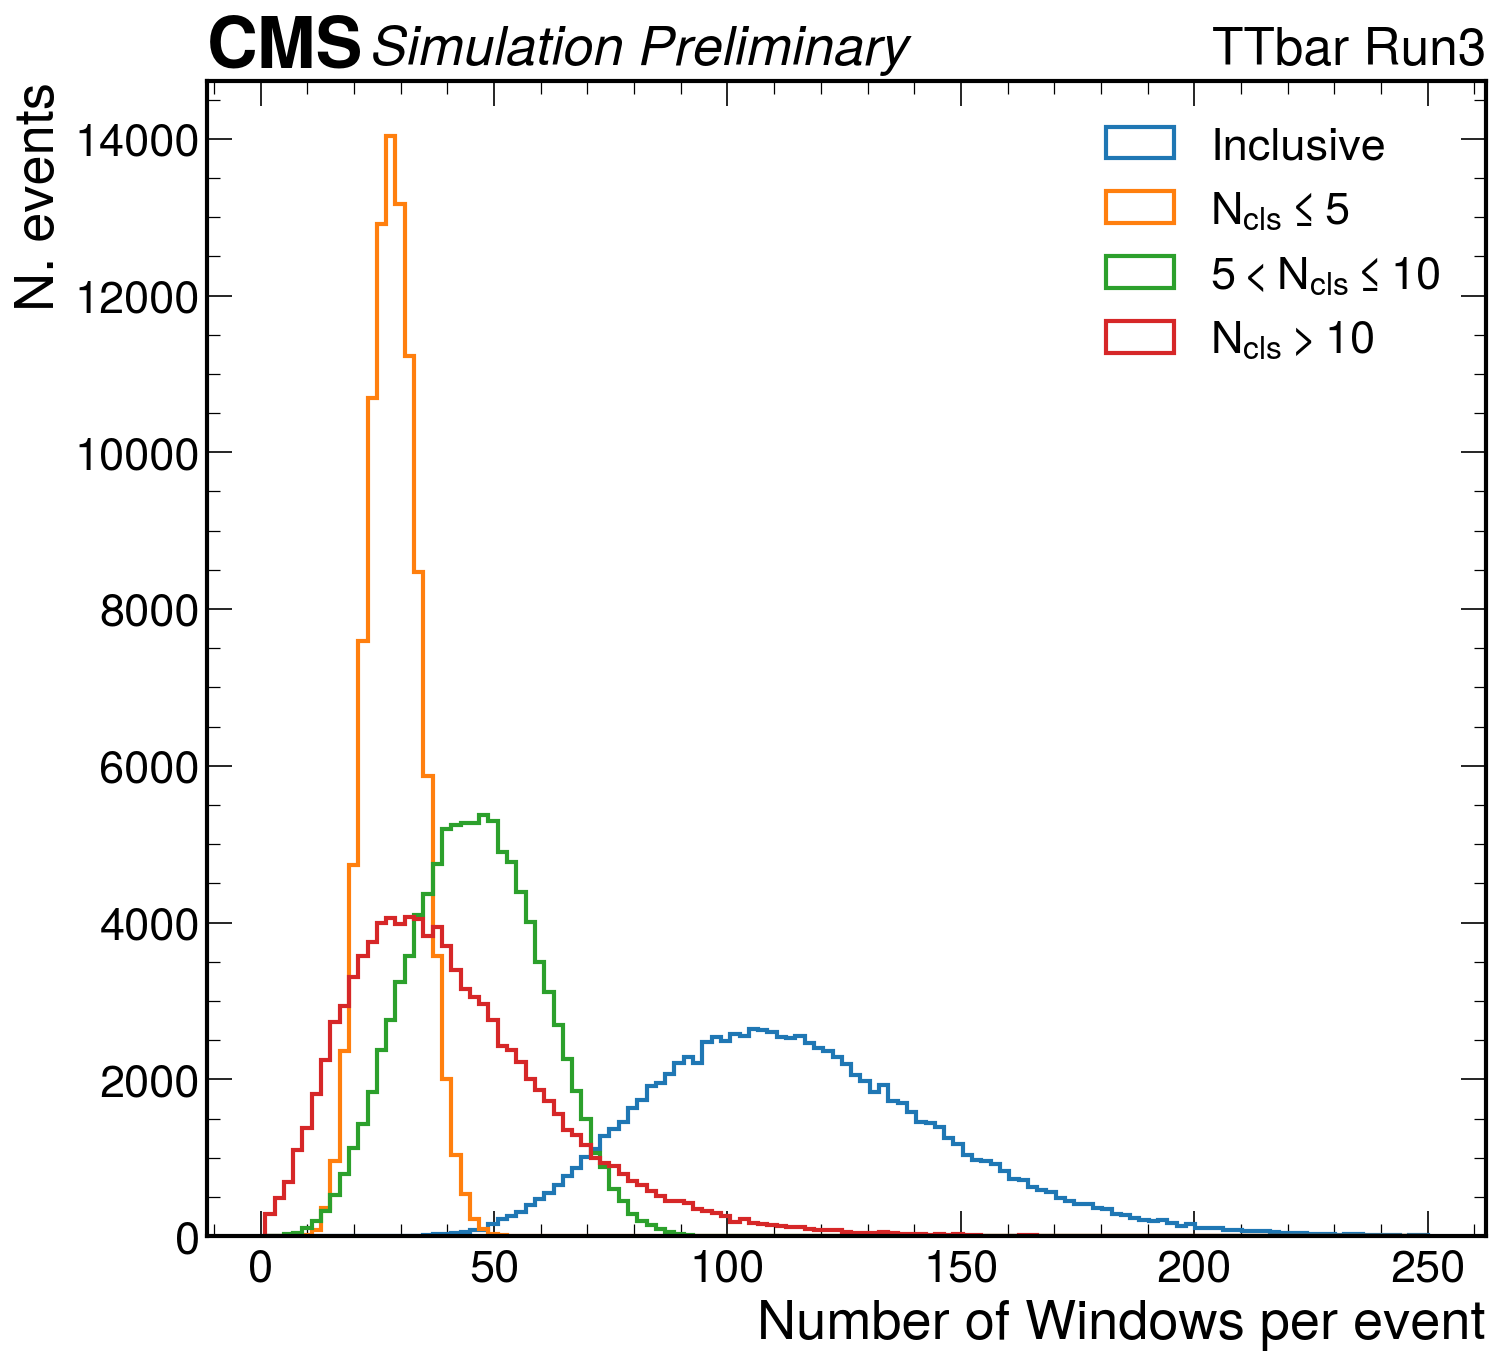

In [174]:
fig = plt.figure(figsize=(11,10), dpi=150)
ax = plt.gca()
ax.hist(nwind, bins=125, range=(1,250), histtype="step", linewidth=2, label="Inclusive")

nwind5 = ak.num(data[ak.num(data, axis=2)<=5], axis=1)
nwind10 = ak.num(data[(ak.num(data, axis=2)>5)&(ak.num(data, axis=2)<=10)], axis=1)
nwindinf = ak.num(data[(ak.num(data, axis=2)>10)], axis=1)

ax.hist(nwind5,bins=125, range=(1,250), histtype="step", linewidth=2, label="$N_{cls} \leq 5$")
ax.hist(nwind10,bins=125, range=(1,250), histtype="step", linewidth=2, label="$5 < N_{cls} \leq 10$")
ax.hist(nwindinf,bins=125, range=(1,250), histtype="step", linewidth=2, label="$N_{cls} > 10$")
ax.set_xlabel("Number of Windows per event")
ax.set_ylabel("N. events")
#ax.set_yscale("log")

ax.legend()

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="number_of_window_in_events_by_ncls"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")
    

In [183]:
ncls = ak.num(data, axis=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


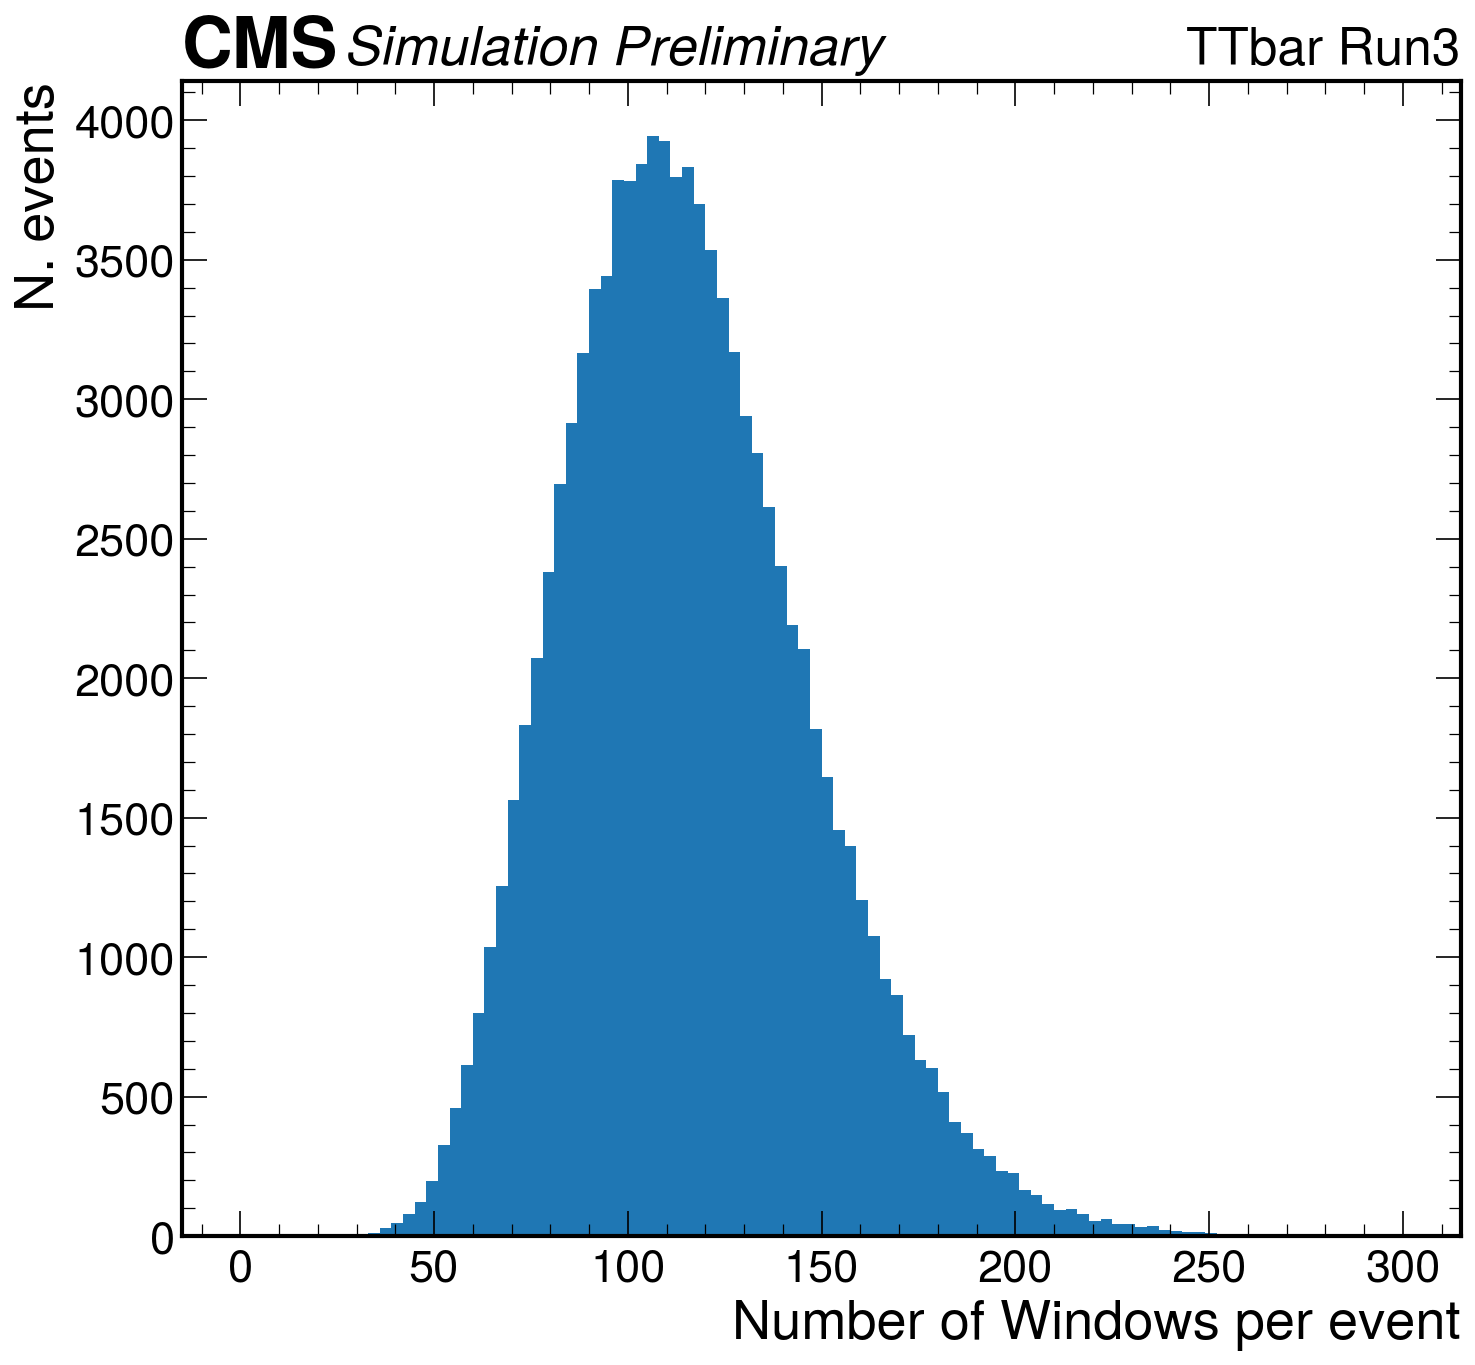

In [182]:
fig = plt.figure(figsize=(11,10), dpi=150)
ax = plt.gca()

ax.hist(nwind, bins=100, range=(0,300))




ax.set_xlabel("Number of Windows per event")
ax.set_ylabel("N. events")
#ax.set_yscale("log")

ax.legend()

hep.cms.label(llabel="Simulation Preliminary", rlabel="TTbar Run3", loc=0, ax=ax)
if output_folder!=None:
    var ="number_of_window_in_events_by_ncls"
    os.makedirs(output_folder, exist_ok=True)
    fig.savefig(output_folder + f"/{var}.png")
    fig.savefig(output_folder + f"/{var}.pdf")
    fig.savefig(output_folder + f"/{var}.svg")
    